# 1. Perkenalan

<b><u>Graded Chalengge 5</u></b>

Nama : Muhammad Azhar Khaira

Batch : RMT-033

Data : [Data](https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=ml_datasets&t=credit_card_default&page=table&project=hacktiv8-426908&ws=!1m5!1m4!4m3!1sbigquery-public-data!2sml_datasets!3scredit_card_default)

Objectives:

Project kali ini bertujuan membuat model untuk memprediksi gagal bayar atau tidak dari pemegang kartu kredit berdasarkan pola pembayaran bulan sebelumnya pada layanan kredit.

Model dibuat menggunakan model logistic regression, K-Nearest Neighbors (KNN) dan Support Vector Machine (SVM) yang kemudian dilakukan hyperparameter tunning.

Matriks evaluasi yang digunakan adalah Accuracy, Precision, Recall dan F1 Score.

Conceptual Problems:
1. Apakah yang dimaksud dengan coeficient pada logistic regression?
2. Apakah fungsi parameter kernel pada SVM?
3. Bagaimana cara memilih `K` yang optimal pada KNN ?
4. Apa yang dimaksud dengan metrics-metrics berikut: Accuracy, Precision, Recall, F1 Score, dan kapan waktu yang tepat untuk menggunakannya ?

# 2. Query SQL

In [ ]:
# bigquery authentication
from google.colab import auth
from google.cloud import bigquery
auth.authenticate_user()
print('Authenticated')

project_id_acc = "hacktiv8-426908"
client = bigquery.Client(project=project_id_acc)

In [ ]:
# query selected column dari dataset to dataframe
df_ori = client.query('''
select
  limit_balance,
  cast(sex as int64) as sex,
  cast(education_level as int64) as education_level,
  cast(marital_status as int64) as marital_status,
  age,
  pay_0,
  pay_2,
  pay_3,
  pay_4,
  cast(pay_5 as float64) as pay_5,
  cast(pay_6 as float64) as pay_6,
  bill_amt_1,
  bill_amt_2,
  bill_amt_3,
  bill_amt_4,
  bill_amt_5,
  bill_amt_6,
  pay_amt_1,
  pay_amt_2,
  pay_amt_3,
  pay_amt_4,
  pay_amt_5,
  pay_amt_6,
  cast(default_payment_next_month as int64) as default_payment_next_month
from `bigquery-public-data.ml_datasets.credit_card_default`
limit 65769
''').to_dataframe()

In [ ]:
# save dataset named df_ori to csv
df_ori.to_csv("P1G5_Set_1_azhar_khaira.csv", index=False)

In [ ]:
# query field_path column to dataframe untuk melihat deskripsi column
df_ori_col_field_paths = client.query('''
select *
from
  `bigquery-public-data.ml_datasets.INFORMATION_SCHEMA.COLUMN_FIELD_PATHS`
where
  table_name = 'credit_card_default'
''').to_dataframe()

In [ ]:
# save COLUMN_FIELD_PATHS named df_ori_col_field_paths to csv
df_ori.to_csv("df_ori_col_field_paths.csv", index=False)

# 3. Import Libraries

In [3161]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, classification_report
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import joblib

# 4. Data Loading

In [3162]:
# read dataset csv to dataframe named df_ori
df_ori = pd.read_csv("P1G5_Set_1_azhar_khaira.csv")

In [3163]:
# set display show all column
pd.set_option("display.max_columns", None)

In [3164]:
# show df_ori 10 data awal
df_ori.head(10)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,0.0,61454.0,61808.0,62290.0,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,0.0,49221.0,49599.0,50942.0,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,0.0,19568.0,19420.0,15535.0,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,0.0,18457.0,22815.0,27086.0,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,0.0,159919.0,68686.0,161192.0,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0
5,300000.0,2,4,2,32.0,0.0,0.0,0.0,0.0,0.0,-1.0,54053.0,65235.0,64747.0,65150.0,-450.0,700.0,15235.0,1491.0,1303.0,0.0,2000.0,1400.0,0
6,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0.0,0.0,58180.0,59134.0,61156.0,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0
7,200000.0,1,1,1,58.0,0.0,0.0,0.0,0.0,0.0,0.0,192461.0,195970.0,122214.0,124647.0,126921.0,129167.0,7822.0,4417.0,4446.0,4597.0,4677.0,4698.0,0
8,500000.0,1,1,1,39.0,0.0,0.0,0.0,0.0,0.0,0.0,133598.0,167378.0,171106.0,174500.0,137406.0,204975.0,54209.0,4607.0,4603.0,5224.0,207440.0,7509.0,0
9,230000.0,1,1,1,48.0,0.0,0.0,0.0,0.0,0.0,0.0,160879.0,161797.0,165107.0,105508.0,108101.0,110094.0,7000.0,6607.0,3773.0,4290.0,4164.0,2000.0,0


In [3165]:
# show df_ori 10 data akhir
df_ori.tail(10)

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2955,360000.0,2,2,2,26.0,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,1968.0,459.0,2500.0,0.0,0.0,0.0,463.0,2500.0,0.0,0.0,0.0,0.0,0
2956,100000.0,1,3,1,40.0,0.0,0.0,-1.0,-1.0,-2.0,-2.0,12878.0,7702.0,2377.0,0.0,0.0,0.0,2000.0,2377.0,40000.0,0.0,0.0,0.0,0
2957,30000.0,2,3,1,48.0,1.0,-1.0,-1.0,-2.0,-2.0,-2.0,-100.0,100.0,0.0,0.0,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0
2958,80000.0,2,3,1,39.0,-1.0,-1.0,-1.0,-1.0,-2.0,-1.0,5280.0,5000.0,5000.0,0.0,0.0,5000.0,5000.0,5000.0,0.0,5000.0,5000.0,470.0,0
2959,20000.0,1,3,2,26.0,-1.0,-1.0,-1.0,-2.0,-2.0,-2.0,96.0,780.0,0.0,0.0,0.0,0.0,1560.0,0.0,0.0,0.0,0.0,0.0,0
2960,80000.0,2,3,2,28.0,-1.0,-1.0,-1.0,-2.0,-2.0,-2.0,4280.0,2800.0,0.0,0.0,0.0,0.0,2800.0,0.0,0.0,0.0,0.0,0.0,0
2961,50000.0,2,3,1,51.0,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,752.0,300.0,5880.0,0.0,0.0,0.0,300.0,5880.0,0.0,0.0,0.0,0.0,1
2962,450000.0,2,2,1,38.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,390.0,390.0,390.0,390.0,390.0,390.0,390.0,780.0,390.0,390.0,390.0,390.0,1
2963,50000.0,2,2,1,44.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,1473.0,390.0,390.0,390.0,390.0,0.0,390.0,390.0,390.0,390.0,0.0,780.0,0
2964,290000.0,2,2,1,39.0,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-70.0,9540.0,390.0,3184.0,390.0,390.0,10000.0,800.0,3184.0,390.0,390.0,6617.0,0


In [3166]:
# dataset info
df_ori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2965 non-null   float64
 1   sex                         2965 non-null   int64  
 2   education_level             2965 non-null   int64  
 3   marital_status              2965 non-null   int64  
 4   age                         2965 non-null   float64
 5   pay_0                       2965 non-null   float64
 6   pay_2                       2965 non-null   float64
 7   pay_3                       2965 non-null   float64
 8   pay_4                       2965 non-null   float64
 9   pay_5                       2965 non-null   float64
 10  pay_6                       2965 non-null   float64
 11  bill_amt_1                  2965 non-null   float64
 12  bill_amt_2                  2965 non-null   float64
 13  bill_amt_3                  2965 

insight:
- data set terdiri dari 2965 baris dan 24 kolom
- bertipe float64 sebanyak 20 kolom dan int64 sebanyak 4 kolom
- tipe data sudah sesuai dengan informasi yang terkandung pada masing-masing kolom

In [3167]:
# dataset describe
df_ori.describe().T

,count,mean,std,min,25%,50%,75%,max
limit_balance,2965.0,163369.308600,125030.415472,10000.0,50000.0,140000.0,230000.0,800000.0
sex,2965.0,1.607757,0.488333,1.0,1.0,2.0,2.0,2.0
education_level,2965.0,1.849578,0.778184,0.0,1.0,2.0,2.0,6.0
marital_status,2965.0,1.559865,0.522317,0.0,1.0,2.0,2.0,3.0
age,2965.0,35.193255,9.109439,21.0,28.0,34.0,41.0,69.0
pay_0,2965.0,0.005059,1.114395,-2.0,-1.0,0.0,0.0,8.0
pay_2,2965.0,-0.122428,1.180784,-2.0,-1.0,0.0,0.0,7.0
pay_3,2965.0,-0.141653,1.183630,-2.0,-1.0,0.0,0.0,7.0
pay_4,2965.0,-0.185160,1.178322,-2.0,-1.0,0.0,0.0,8.0
pay_5,2965.0,-0.225295,1.159003,-2.0,-1.0,0.0,0.0,7.0


insight:
- rata-rata limit_balance 163369.3
- rata-rata age pengguna kartu kredit 35 tahun
- rata-rata limit_balance > dari mediannya, kemungkinan memiliki skew
- rentang limit_balance mulai dari 10,000 hingga 800,000
- rentang age mulai dari 21 hingga 69

## 4.1. Check Duplicate

In [3168]:
# cek duplikat
df_ori.duplicated().sum()

1

insight:
- terdapat 1 data duplikat

In [3169]:
# show data duplikat
df_ori[df_ori.duplicated(keep=False)]

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2806,200000.0,2,1,1,34.0,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2815,200000.0,2,1,1,34.0,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


insight:
- data duplikat tidak akan didrop berdasarkan asumsi bahwa data tersebut benar dan kemungkinan pemilik kredit berbeda namun memiliki profil data yang sama

## 4.2. Check Missing Value

In [3170]:
# cek missing value
df_ori.isnull().sum()

limit_balance                 0
sex                           0
education_level               0
marital_status                0
age                           0
pay_0                         0
pay_2                         0
pay_3                         0
pay_4                         0
pay_5                         0
pay_6                         0
bill_amt_1                    0
bill_amt_2                    0
bill_amt_3                    0
bill_amt_4                    0
bill_amt_5                    0
bill_amt_6                    0
pay_amt_1                     0
pay_amt_2                     0
pay_amt_3                     0
pay_amt_4                     0
pay_amt_5                     0
pay_amt_6                     0
default_payment_next_month    0
dtype: int64

insight:
- tidak ada missing value

## 4.3. Check Unique Value

In [3171]:
# read df_ori_col_field_paths
df_ori_col_field_paths = pd.read_csv("df_ori_col_field_paths.csv")

# show df_ori_col_field_paths column
df_ori_col_field_paths.columns

Index(['table_catalog', 'table_schema', 'table_name', 'column_name',
       'field_path', 'data_type', 'description', 'collation_name',
       'rounding_mode'],
      dtype='object')

In [3172]:
# show decription of column
df_ori_col_field_paths[["column_name", "description"]]

,column_name,description
0,id,Anonymized ID of each client
1,limit_balance,Amount of given credit in NT dollars (includes individual and family/supplementary credit
2,sex,"Gender (1=male, 2=female)"
3,education_level,"Education Level (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)"
4,marital_status,"Marital status (1=married, 2=single, 3=others)"
5,age,Age in years
6,pay_0,"Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)"
7,pay_2,"Repayment status in August, 2005 (scale same as above)"
8,pay_3,"Repayment status in July, 2005 (scale same as above)"
9,pay_4,"Repayment status in June, 2005 (scale same as above)"


In [3173]:
# set besar kolom agar text panjang terlihat
pd.set_option("display.max_colwidth", None)

# show decription dari column sex, education_level, marital_status, default_payment_next_month
df_ori_col_field_paths[df_ori_col_field_paths["column_name"].isin(["sex", "education_level", "marital_status", "default_payment_next_month", "pay_0"])][["column_name", "description"]]

,column_name,description
2,sex,"Gender (1=male, 2=female)"
3,education_level,"Education Level (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)"
4,marital_status,"Marital status (1=married, 2=single, 3=others)"
6,pay_0,"Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)"
24,default_payment_next_month,"Default payment (1=yes, 0=no)"


insight:
- value pada kolom sex, education_level, marital_status, pay_0 hingga pay_6 dan default_payment_next_month merupakan kodefikasi dengan penjelasannya pada kolom description

In [3174]:
# value count limit_balance
df_ori["limit_balance"].value_counts()

limit_balance
50000.0     348
20000.0     203
200000.0    150
30000.0     148
80000.0     145
100000.0    123
150000.0    122
180000.0     97
210000.0     84
140000.0     83
120000.0     80
360000.0     78
70000.0      76
90000.0      71
260000.0     70
130000.0     69
60000.0      68
230000.0     68
300000.0     67
160000.0     62
500000.0     56
240000.0     56
110000.0     54
170000.0     52
280000.0     50
10000.0      46
220000.0     43
290000.0     37
320000.0     32
250000.0     28
310000.0     28
40000.0      26
400000.0     25
350000.0     24
420000.0     20
270000.0     19
390000.0     16
330000.0     16
380000.0     16
340000.0     15
190000.0     12
410000.0     12
450000.0      9
460000.0      8
490000.0      8
370000.0      8
470000.0      7
440000.0      6
480000.0      5
430000.0      5
510000.0      4
530000.0      3
560000.0      1
680000.0      1
700000.0      1
800000.0      1
780000.0      1
750000.0      1
620000.0      1
Name: count, dtype: int64

insight:
- limit_balance sangat bervariasi dengan rentang 10,000 hingga 800,000
- limit_balance 50,000 dan 20,000 berfrekuensi lebih dari 200, banyak pemegang kredit dengan limit_balance tersebut

In [3175]:
# value counts sex
df_ori["sex"].value_counts()

sex
2    1802
1    1163
Name: count, dtype: int64

insight:
- Gender (1=male, 2=female)
- sex terdiri dari dua gender yang diberi kode 1 dan 2
- sex dengan kode 2 (female) berfrekuensi lebih tinggi dari pada sex kode 1 (male)

In [3176]:
# value counts education_level
df_ori["education_level"].value_counts()

education_level
2    1400
1    1039
3     483
5      24
4      13
6       4
0       2
Name: count, dtype: int64

In [3177]:
# cek education_level = 0
df_ori[df_ori["education_level"] == 0]

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2749,100000.0,1,0,2,37.0,0.0,0.0,-2.0,-2.0,-2.0,-2.0,7642.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2750,250000.0,1,0,1,35.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,22839.0,7745.0,12035.0,33604.0,0.0,1190.0,7783.0,12046.0,33718.0,0.0,1190.0,590.0,0


insight:
- Education Level (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
- education_level terdiri dari tujuh kategori diberi kode 0 hingga 6, diasumsikan kode tersebut berjenjang dari pendidikan rendah hingga tinggi
- education_level kode 2 (university) memiliki frekuensi tertinggi
- ada pengkategorian yang sama pada kode 5 dan 6
- terdapat education_level 0 yang tidak ada pada deskripsi kategori dari education_level

In [3178]:
# value counts marital_status
df_ori["marital_status"].value_counts()

marital_status
2    1594
1    1332
3      35
0       4
Name: count, dtype: int64

In [3179]:
# cek marital_status = 0
df_ori[df_ori["marital_status"] == 0]

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
1248,110000.0,2,3,0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,89955.0,89989.0,84229.0,79288.0,73315.0,63818.0,7908.0,4000.0,5000.0,3000.0,3000.0,3000.0,0
1802,100000.0,2,3,0,56.0,1.0,2.0,0.0,0.0,2.0,2.0,28625.0,27969.0,28812.0,31134.0,30444.0,32460.0,0.0,1500.0,2700.0,0.0,2400.0,0.0,0
2095,50000.0,1,3,0,50.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,45771.0,23343.0,0.0,3400.0,2769.0,0.0,2266.0,0.0,3400.0,2769.0,1700.0,0.0,0
2665,200000.0,2,3,0,45.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,399.0,2430.0,0.0,399.0,1396.0,0.0,2430.0,0.0,399.0,1396.0,0.0,0.0,0


insight:
- Marital status (1=married, 2=single, 3=others)
- marital_status terdiri dari empat kategori diberi kode 0 hingga 3
- marital_status kode 2 (single) memiliki frekuensi tertinggi
- terdapat marital_status 0 sebanyak 4 data akan ditindaklanjut untuk diubah menjadi kategori 3 (others)

In [3180]:
# value counts age
df_ori["age"].value_counts()

age
30.0    171
29.0    149
27.0    146
28.0    138
26.0    138
31.0    122
34.0    122
24.0    120
32.0    119
25.0    119
36.0    114
35.0    104
33.0    104
37.0     99
41.0     99
23.0     95
39.0     90
38.0     90
40.0     86
42.0     79
43.0     68
45.0     55
47.0     54
22.0     49
46.0     48
44.0     44
48.0     41
49.0     41
50.0     38
52.0     37
53.0     30
55.0     30
51.0     25
56.0     19
54.0     16
61.0     10
57.0     10
58.0      9
21.0      7
60.0      7
63.0      4
62.0      4
59.0      4
65.0      3
66.0      2
69.0      2
67.0      2
64.0      1
68.0      1
Name: count, dtype: int64

- age sangat bervariasi dengan rentang 21 hingga 69
- frekuensi age lebih dari 100 ada pada rentang age 24 sampai 36, artinya banyak yang menggunakan kredit pada rentang usia tersebut

In [3181]:
# value counts default_payment_next_month
df_ori["default_payment_next_month"].value_counts()

default_payment_next_month
0    2330
1     635
Name: count, dtype: int64

insight:
- Default payment (1=yes, 0=no)
- banyak pemegang kredit tidak gagal bayar pada bulan berikutnya

In [3182]:
# value counts pay_0
df_ori["pay_0"].value_counts()

pay_0
 0.0    1516
-1.0     540
 1.0     356
 2.0     262
-2.0     247
 3.0      29
 4.0       7
 8.0       3
 5.0       2
 7.0       2
 6.0       1
Name: count, dtype: int64

In [3183]:
df_ori

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,0.0,61454.0,61808.0,62290.0,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,0.0,49221.0,49599.0,50942.0,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,0.0,19568.0,19420.0,15535.0,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,0.0,18457.0,22815.0,27086.0,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,0.0,159919.0,68686.0,161192.0,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2960,80000.0,2,3,2,28.0,-1.0,-1.0,-1.0,-2.0,-2.0,-2.0,4280.0,2800.0,0.0,0.0,0.0,0.0,2800.0,0.0,0.0,0.0,0.0,0.0,0
2961,50000.0,2,3,1,51.0,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,752.0,300.0,5880.0,0.0,0.0,0.0,300.0,5880.0,0.0,0.0,0.0,0.0,1
2962,450000.0,2,2,1,38.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,390.0,390.0,390.0,390.0,390.0,390.0,390.0,780.0,390.0,390.0,390.0,390.0,1
2963,50000.0,2,2,1,44.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,1473.0,390.0,390.0,390.0,390.0,0.0,390.0,390.0,390.0,390.0,0.0,780.0,0


insight:
- Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
- diasumsikan nilai -2 adalah kondisi dimana tidak ada tagihan atau tagihan dilakukan pelunasan pada bulan yang sama dengan pembuatan tagihan
- diasumsikan nilai -1 adalah kondisi dimana tagihan dibayar tepat waktu dan dilakukan pelunasan
- diasumsikan nilai 0 adalah pembayaran tepat waktu tetapi tidak dilakukan pelunasan
- diasumsikan untuk nilai positif adalah pembayaran terlambat, semakin positif semakin terlambat dari tenggat waktu pembayaran

## 4.4. Data Loading Conclusion

- terdapat 1 data duplikat namun tidak akan dilakukan tindak lanjut atau dibiarkan dengan asumsi bahwa data tersebut benar
- tidak terdapat missing value
- limit_balance dengan frekuensi tertinggi adalah 50,000
- sex dengan frekuensi tertinggi adalah sex kode 2 (female)
- education_level dengan frekuensi tertinggi adalah education_level kode 2 (university)
- marital_status dengan frekuensi tertinggi adalah marital_status kode 2 (single)
- age dengan frekuensi tertinggi adalah 30
- terdapat kode education_level dengan kategori yang sama yaitu 5 dan 6 dengan deskripsi `unkown`
- terdapat education_level 0 yang tidak ada pada deskripsi education_level
- terdapat marital_status 0yang tidak ada pada deskripsi marital_status
- pay_0 berisikan rentang pembayaran dari tenggat waktu

# 5. Exploratory Data Analysis (EDA)

In [3184]:
# dataframe column
df_ori.columns

Index(['limit_balance', 'sex', 'education_level', 'marital_status', 'age',
       'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt_1',
       'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6',
       'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5',
       'pay_amt_6', 'default_payment_next_month'],
      dtype='object')

## 5.1. Default Payment Next Month

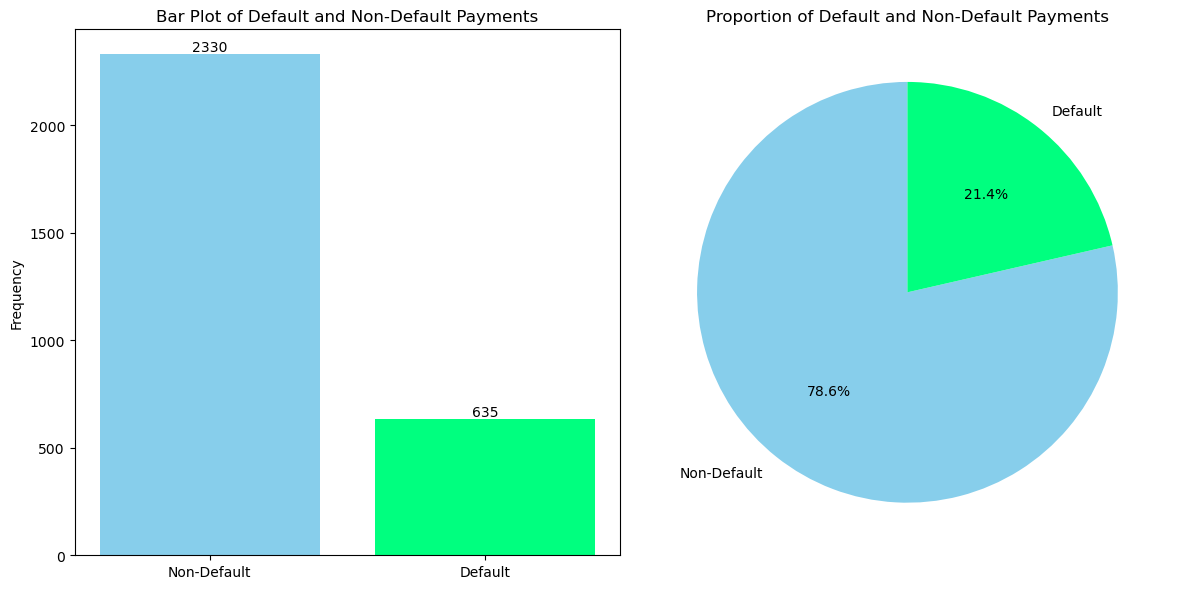

In [3185]:
# figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# barplot
dpnm_counts = df_ori["default_payment_next_month"].value_counts()
barplot = ax1.bar(dpnm_counts.index, dpnm_counts.values, color=["skyblue", "springgreen"])

# label
for bar, count in zip(barplot, dpnm_counts.values):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), count, ha="center", va="bottom")
ax1.set_xticks([0, 1])
ax1.set_xticklabels(["Non-Default", "Default"])
ax1.set_ylabel("Frequency")
ax1.set_title("Bar Plot of Default and Non-Default Payments")

# pie chart
dpnm_labels = ["Non-Default", "Default"]
dpnm_sizes = df_ori["default_payment_next_month"].value_counts().values
ax2.pie(dpnm_sizes, labels=dpnm_labels, autopct="%1.1f%%", colors=["skyblue", "springgreen"], startangle=90)
# label
ax2.set_title("Proportion of Default and Non-Default Payments")

plt.tight_layout()
plt.show()

insight:
- pemegang kredit didominasi oleh pemegang kredit yang tidak gagal bayar dengan persentase 78.6%
- artinya setidaknya 2,330 pemegang kartu kredit tidak gagal bayar

## 5.2. Limit Balance

In [3186]:
# limit_balance describe
df_ori["limit_balance"].describe()

count      2965.000000
mean     163369.308600
std      125030.415472
min       10000.000000
25%       50000.000000
50%      140000.000000
75%      230000.000000
max      800000.000000
Name: limit_balance, dtype: float64

insight:
- range limit_balance mulai dari 10,000 hingga 800,000
- rata-rata limit_balance 163,369.3
- titik tengah limit_balance 140,000
- rata-rata > titik tengah, kemungkinan memiliki skew

In [3187]:
skewness_limit_balance = df_ori["limit_balance"].skew()
print(f"skewness limit_balance = {skewness_limit_balance}")

skewness limit_balance = 1.0004416437793324


insight:
- limit_balance memiliki skewness positif, kemungkinan menunjukan ada lebih banyak nilai limit_balance yang rendah dari pada nilai yang tinggi dan kemungkinan memiliki outliers pada nilai yang tinggi sehingga menarik nilai mean menjadi lebih tinggi dari pada median

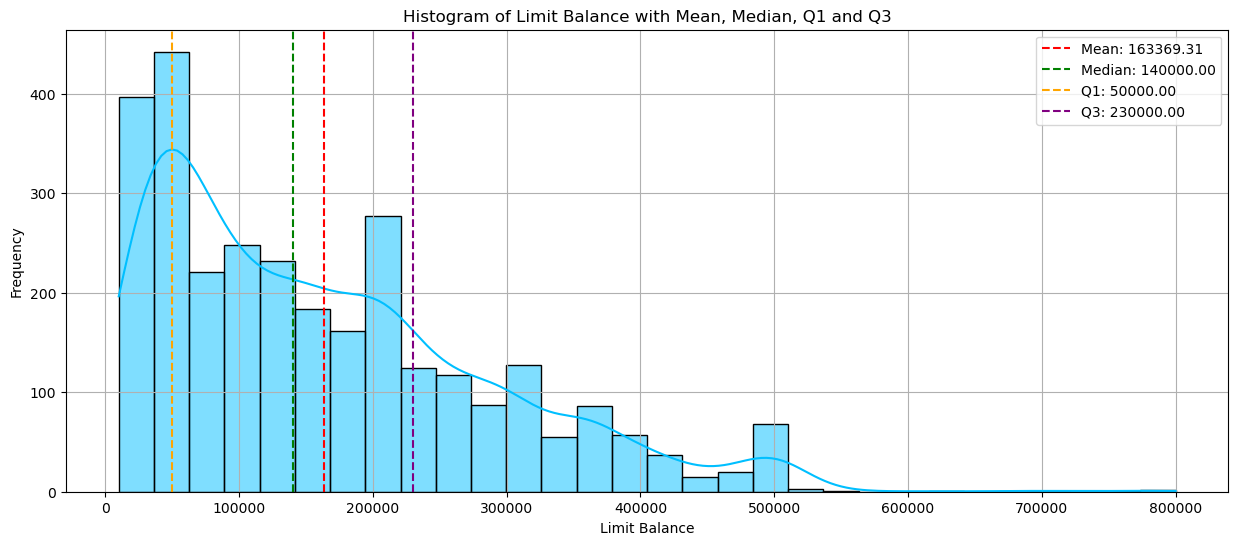

In [3188]:
# statistic
mean_limit_balance = df_ori["limit_balance"].mean()
median_limit_balance = df_ori["limit_balance"].median()
q1_limit_balance = df_ori["limit_balance"].quantile(0.25)
q3_limit_balance = df_ori["limit_balance"].quantile(0.75)

# histogram plot
plt.figure(figsize=(15, 6))
sns.histplot(df_ori["limit_balance"], bins=30, kde=True, color="deepskyblue")

# median, mean, Q1, Q3 lines
plt.axvline(mean_limit_balance, color="red", linestyle="dashed", linewidth=1.5, label=f"Mean: {mean_limit_balance:.2f}")
plt.axvline(median_limit_balance, color="green", linestyle="dashed", linewidth=1.5, label=f"Median: {median_limit_balance:.2f}")
plt.axvline(q1_limit_balance, color="orange", linestyle="dashed", linewidth=1.5, label=f"Q1: {q1_limit_balance:.2f}")
plt.axvline(q3_limit_balance, color="purple", linestyle="dashed", linewidth=1.5, label=f"Q3: {q3_limit_balance:.2f}")

# label
plt.xlabel("Limit Balance")
plt.ylabel("Frequency")
plt.title("Histogram of Limit Balance with Mean, Median, Q1 and Q3")
plt.legend()

# plot
plt.grid(True)
plt.show()

insight:
- distribusi limit_balance menunjukan lebih banyaknya limit_balance yang rendah dari pada yang tinggi, ditunjukan dengan pola frequency yang tinggi di awal kemudian relatif menurun dari limit_balance terendah hingga tertinggi.
- artinya kebanyakan pemegang kartu kredit memiliki limit balance kurang dari 100,000

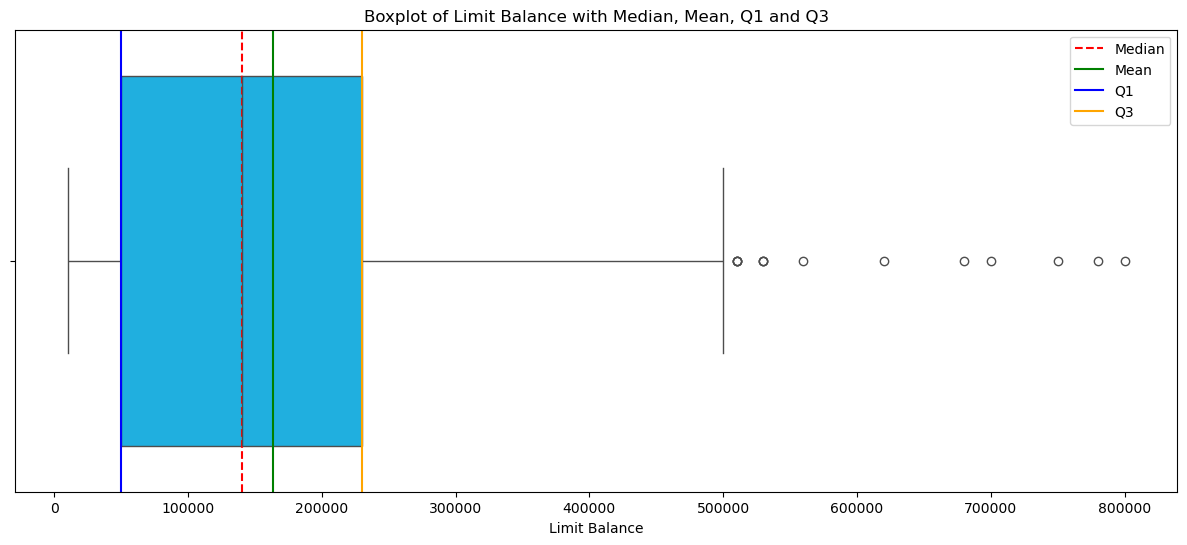

In [3189]:
# boxplot
plt.figure(figsize=(15, 6))
sns.boxplot(x=df_ori["limit_balance"], color="deepskyblue")

# median, mean, Q1, Q3 lines
plt.axvline(median_limit_balance, color="red", linestyle="--", label="Median")
plt.axvline(mean_limit_balance, color="green", linestyle="-", label="Mean")
plt.axvline(q1_limit_balance, color="blue", linestyle="-", label="Q1")
plt.axvline(q3_limit_balance, color="orange", linestyle="-", label="Q3")

# label
plt.title("Boxplot of Limit Balance with Median, Mean, Q1 and Q3")
plt.xlabel("Limit Balance")
plt.legend()

# show plot
plt.show()


insight:
- titik-titik di sebelah kanan boxplot menunjukan kemungkinan adanya outliers dengan nilai yang tinggi mulai dari 500,000 hingga 800,000

## 5.3. Sex

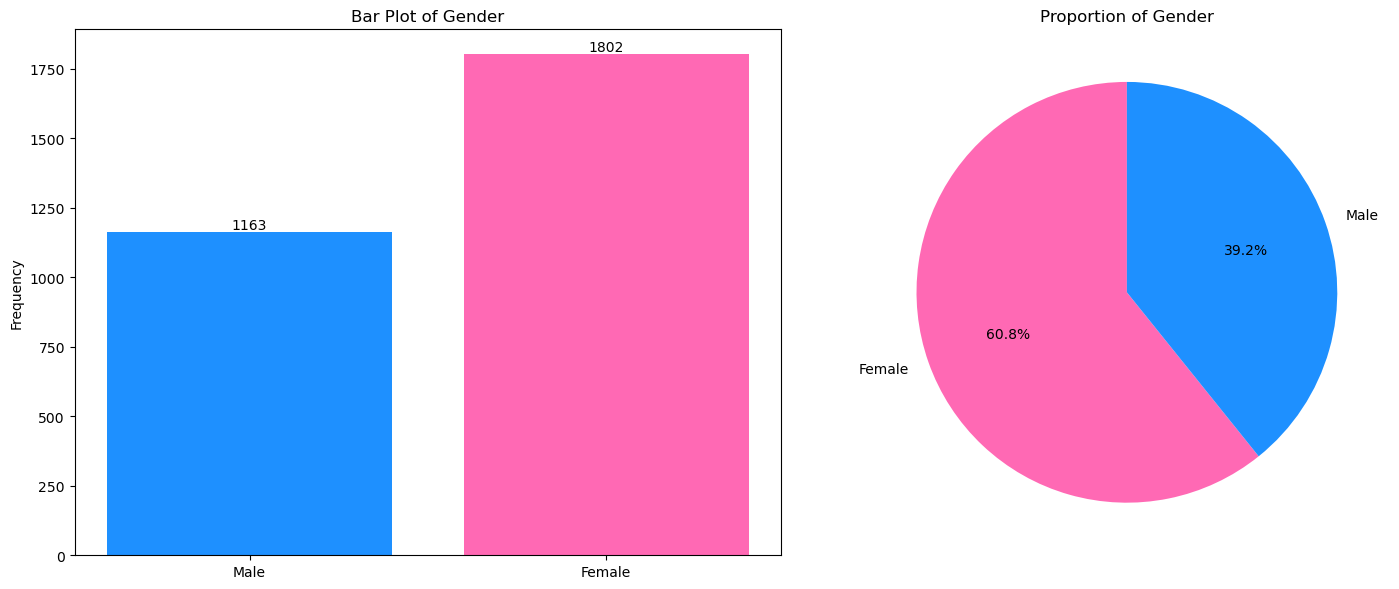

In [3190]:
# figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# barplot
dpnm_counts = df_ori["sex"].value_counts()
barplot = ax1.bar(dpnm_counts.index, dpnm_counts.values, color=["hotpink", "dodgerblue"])

# label barplot
for bar, count in zip(barplot, dpnm_counts.values):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), count, ha="center", va="bottom")
ax1.set_xticks([1, 2])
ax1.set_xticklabels(["Male", "Female"])
ax1.set_ylabel("Frequency")
ax1.set_title("Bar Plot of Gender")

# pie chart
dpnm_labels = ["Female", "Male"]
dpnm_sizes = df_ori["sex"].value_counts().values
ax2.pie(dpnm_sizes, labels=dpnm_labels, autopct="%1.1f%%", colors=["hotpink", "dodgerblue"], startangle=90)

# label peichart
ax2.set_title("Proportion of Gender")

# show plot
plt.tight_layout()
plt.show()

insight:
- pemegang kartu kredit didominasi oleh gender perempuan dengan persentase 60.8%

## 5.4. Education Level

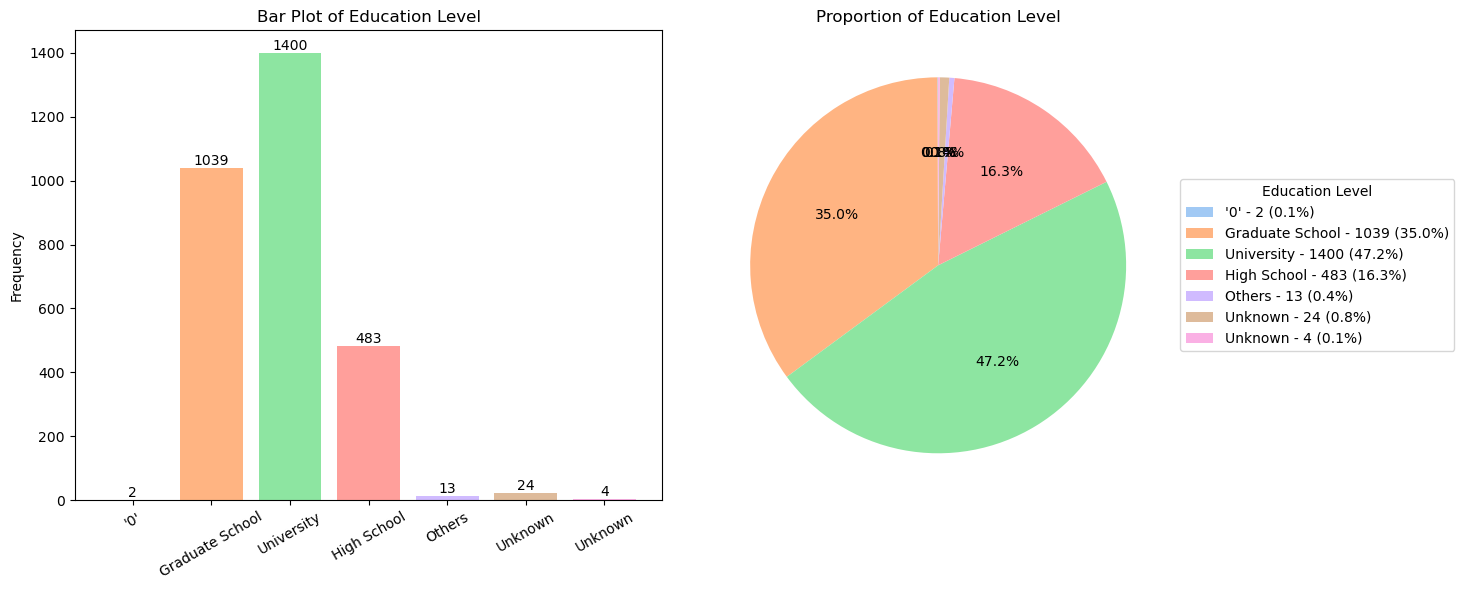

In [3191]:
# figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# barplot
education_counts = df_ori["education_level"].value_counts().sort_index()
barplot = ax1.bar(education_counts.index, education_counts.values, color=sns.color_palette("pastel"))

# label barplot
for bar, count in zip(barplot, education_counts.values):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), count, ha="center", va="bottom")
ax1.set_xticks(education_counts.index)
ax1.set_xticklabels(["'0'", "Graduate School", "University", "High School", "Others", "Unknown", "Unknown"], rotation=30)
ax1.set_ylabel("Frequency")
ax1.set_title("Bar Plot of Education Level")

# pie chart
sizes = education_counts.values
labels = ["'0'", "Graduate School", "University", "High School", "Others", "Unknown", "Unknown"]
wedges, texts, autotexts = ax2.pie(sizes, colors=sns.color_palette("pastel"), startangle=90, autopct="%1.1f%%")

# legend dan label piechart
ax2.legend(wedges, [f"{label} - {size} ({autotext.get_text()})" for label, size, autotext in zip(labels, sizes, autotexts)], title="Education Level", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
ax2.set_title("Proportion of Education Level")

# show plot
plt.tight_layout()
plt.show()

insight:
- pemegang kredit didominasi oleh level edukasi di universitas dengan persentase 47.2%
- terdapat 2 kategori yang sama dengan kode berbeda yaitu unkown
- terdapat kategori 0 yang tidak ada pada deskripsi kolom

In [3192]:
# show data education_level 0, 5, 6
df_ori[df_ori["education_level"].isin([0, 5, 6])].sort_values(by="limit_balance", ascending=False)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2681,360000.0,1,5,1,50.0,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,4767.0,-233.0,-233.0,-233.0,-233.0,-233.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2530,300000.0,2,5,2,26.0,0.0,0.0,0.0,0.0,-2.0,-2.0,293880.0,242669.0,76777.0,34072.0,11632.0,15429.0,11128.0,47009.0,34044.0,11677.0,15483.0,6098.0,0
1658,260000.0,2,5,1,33.0,0.0,-1.0,-1.0,0.0,0.0,0.0,3140.0,2740.0,107139.0,105188.0,104418.0,106990.0,2740.0,107139.0,4000.0,4000.0,4696.0,5000.0,0
1329,260000.0,1,5,1,37.0,0.0,0.0,0.0,0.0,0.0,0.0,9801.0,11115.0,11930.0,12954.0,14246.0,15733.0,1485.0,1300.0,1229.0,1521.0,1728.0,1610.0,0
2750,250000.0,1,0,1,35.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,22839.0,7745.0,12035.0,33604.0,0.0,1190.0,7783.0,12046.0,33718.0,0.0,1190.0,590.0,0
1495,230000.0,1,5,2,40.0,2.0,2.0,2.0,0.0,0.0,0.0,119730.0,120912.0,111819.0,93007.0,92122.0,61583.0,5000.0,0.0,3700.0,3986.0,2900.0,1057.0,0
1336,210000.0,1,5,1,31.0,2.0,0.0,0.0,0.0,0.0,-1.0,195615.0,199825.0,124788.0,126946.0,93925.0,-285.0,9234.0,5185.0,4900.0,4526.0,21787.0,152951.0,0
1332,200000.0,2,5,1,33.0,0.0,0.0,0.0,0.0,0.0,0.0,92707.0,73970.0,122304.0,116674.0,89694.0,68256.0,3112.0,50000.0,6760.0,3486.0,2476.0,2500.0,0
2912,200000.0,2,5,2,48.0,0.0,0.0,-2.0,-2.0,-2.0,-2.0,198540.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1327,180000.0,1,5,1,40.0,0.0,0.0,0.0,0.0,0.0,0.0,78170.0,80559.0,82947.0,84379.0,85789.0,94088.0,4000.0,4000.0,3100.0,3100.0,10000.0,6000.0,0


insight:
- melihat dari pola data, kategori 0, 5, 6 bisa dikategorikan sebagai missing not at random karena tidak dapat diprediksi atau dijelaskan melalui variabel-variabel yang tertampil

## 5.5. Marital Status

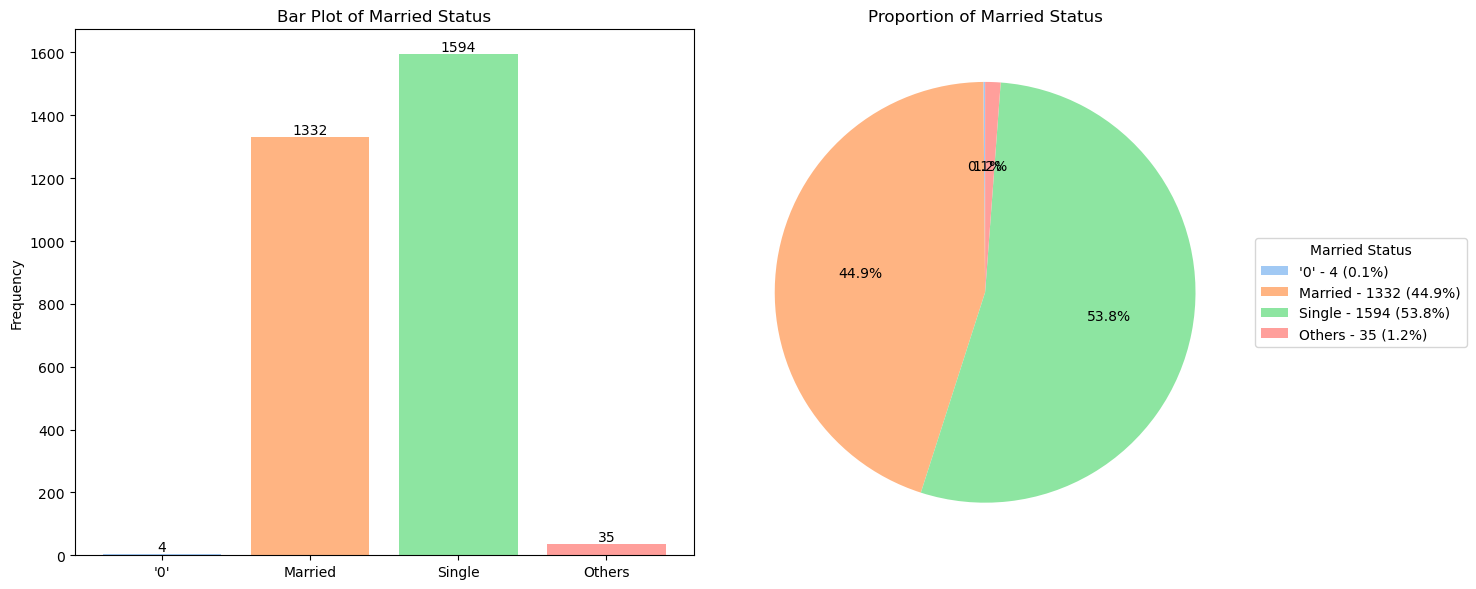

In [3193]:
# figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# barplot
education_counts = df_ori["marital_status"].value_counts().sort_index()
barplot = ax1.bar(education_counts.index, education_counts.values, color=sns.color_palette("pastel"))

# label barplot
for bar, count in zip(barplot, education_counts.values):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), count, ha="center", va="bottom")
ax1.set_xticks(education_counts.index)
ax1.set_xticklabels(["'0'", "Married", "Single", "Others"])
ax1.set_ylabel("Frequency")
ax1.set_title("Bar Plot of Married Status")

# pie chart
sizes = education_counts.values
labels = ["'0'", "Married", "Single", "Others"]
wedges, texts, autotexts = ax2.pie(sizes, colors=sns.color_palette("pastel"), startangle=90, autopct="%1.1f%%")

# legend dan label piechart
ax2.legend(wedges, [f"{label} - {size} ({autotext.get_text()})" for label, size, autotext in zip(labels, sizes, autotexts)], title="Married Status", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
ax2.set_title("Proportion of Married Status")

# show plot
plt.tight_layout()
plt.show()

insight:
- pemegang kredit didominasi oleh orang yang masih lajang dengan persentase 53.8%
- terdapat kategori 0 yang tidak ada pada deskripsi kolom

In [3194]:
# show data marital_status 0
df_ori[df_ori["marital_status"] == 0]

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
1248,110000.0,2,3,0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,89955.0,89989.0,84229.0,79288.0,73315.0,63818.0,7908.0,4000.0,5000.0,3000.0,3000.0,3000.0,0
1802,100000.0,2,3,0,56.0,1.0,2.0,0.0,0.0,2.0,2.0,28625.0,27969.0,28812.0,31134.0,30444.0,32460.0,0.0,1500.0,2700.0,0.0,2400.0,0.0,0
2095,50000.0,1,3,0,50.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,45771.0,23343.0,0.0,3400.0,2769.0,0.0,2266.0,0.0,3400.0,2769.0,1700.0,0.0,0
2665,200000.0,2,3,0,45.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,399.0,2430.0,0.0,399.0,1396.0,0.0,2430.0,0.0,399.0,1396.0,0.0,0.0,0


In [3195]:
# show education_level 3
df_ori[df_ori["education_level"] == 3].head(5)

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
1108,290000.0,1,3,1,61.0,0.0,0.0,0.0,0.0,0.0,0.0,281967.0,288456.0,296084.0,218399.0,200461.0,204637.0,10492.0,12447.0,8973.0,6761.0,6983.0,5980.0,0
1109,230000.0,1,3,1,45.0,0.0,0.0,0.0,0.0,0.0,0.0,203135.0,208225.0,178559.0,172772.0,175057.0,177113.0,10000.0,6528.0,6000.0,6500.0,7000.0,10000.0,0
1110,130000.0,1,3,1,49.0,0.0,0.0,0.0,0.0,0.0,0.0,119466.0,116833.0,106524.0,89412.0,86993.0,87433.0,5044.0,5067.0,5013.0,5002.0,4002.0,5009.0,0
1111,390000.0,1,3,1,49.0,0.0,0.0,0.0,0.0,0.0,0.0,282849.0,281836.0,284397.0,284241.0,285615.0,282611.0,12000.0,13000.0,12000.0,12000.0,10266.0,9800.0,0
1112,50000.0,1,3,1,46.0,0.0,0.0,0.0,0.0,0.0,0.0,62315.0,60180.0,58108.0,55774.0,53589.0,51345.0,2200.0,2200.0,2000.0,1967.0,2002.0,1727.0,0


insight:
- melihat dari pola data, kategori 0 bisa dikategorikan sebagai missing not at random karena tidak dapat diprediksi atau dijelaskan melalui variabel-variabel yang tertampil

## 5.6. Age

In [3196]:
# age describe
df_ori["age"].describe()

count    2965.000000
mean       35.193255
std         9.109439
min        21.000000
25%        28.000000
50%        34.000000
75%        41.000000
max        69.000000
Name: age, dtype: float64

insight:
- rentang usia mulai dari 21 hingga 69 tahun
- rata-rata usia pemegang kredit adalah 35 tahun
- titik tengah usia adalah 34 tahun

In [3197]:
skewness_age = df_ori["age"].skew()
print(f"skewness age = {skewness_age}")

skewness age = 0.7728871800647298


insight:
- age memiliki skewness positif, kemungkinan menunjukan ada lebih banyak usia muda dari pada usia lanjut

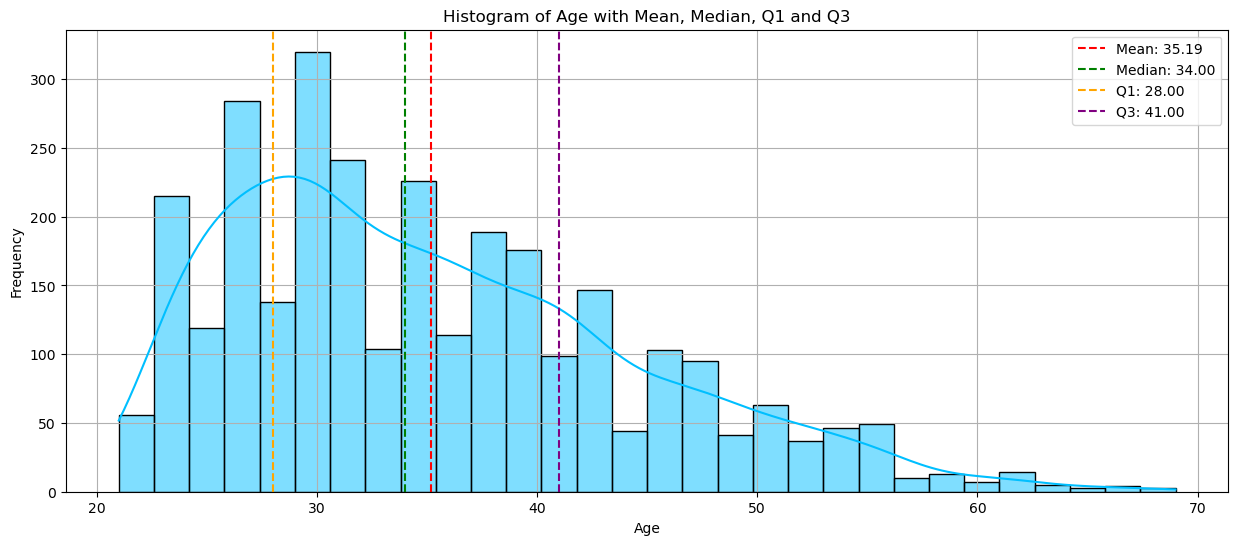

In [3198]:
# statistic
mean_age = df_ori["age"].mean()
median_age = df_ori["age"].median()
q1_age = df_ori["age"].quantile(0.25)
q3_age = df_ori["age"].quantile(0.75)

# histogram plot
plt.figure(figsize=(15, 6))
sns.histplot(df_ori["age"], bins=30, kde=True, color="deepskyblue")

# median, mean, Q1, Q3 lines
plt.axvline(mean_age, color="red", linestyle="dashed", linewidth=1.5, label=f"Mean: {mean_age:.2f}")
plt.axvline(median_age, color="green", linestyle="dashed", linewidth=1.5, label=f"Median: {median_age:.2f}")
plt.axvline(q1_age, color="orange", linestyle="dashed", linewidth=1.5, label=f"Q1: {q1_age:.2f}")
plt.axvline(q3_age, color="purple", linestyle="dashed", linewidth=1.5, label=f"Q3: {q3_age:.2f}")

# label
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Histogram of Age with Mean, Median, Q1 and Q3")
plt.legend()

# plot
plt.grid(True)
plt.show()

insight:
- distribusi age menunjukan pemegang kartu kredit lebih banyaknya pada usia muda hingga paruh baya dari pada usia lanjut, ditunjukan dengan frequency yang naik dari usia muda menuju usia paruh baya dan menurun ketika menuju usia lanjut

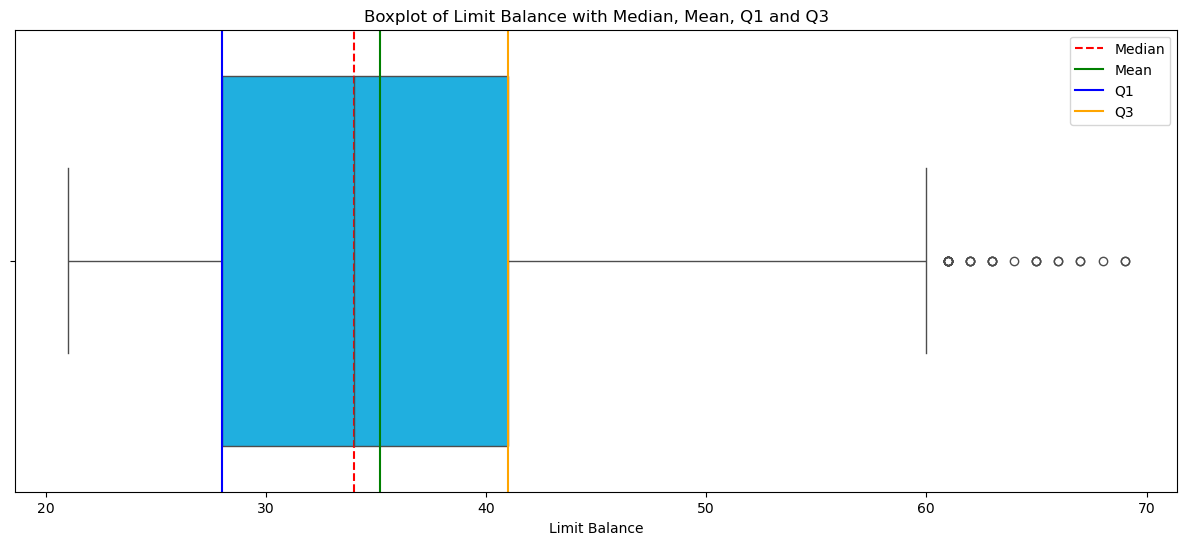

In [3199]:
# boxplot
plt.figure(figsize=(15, 6))
sns.boxplot(x=df_ori["age"], color="deepskyblue")

# median, mean, Q1, Q3 lines
plt.axvline(median_age, color="red", linestyle="--", label="Median")
plt.axvline(mean_age, color="green", linestyle="-", label="Mean")
plt.axvline(q1_age, color="blue", linestyle="-", label="Q1")
plt.axvline(q3_age, color="orange", linestyle="-", label="Q3")

# label
plt.title("Boxplot of Limit Balance with Median, Mean, Q1 and Q3")
plt.xlabel("Limit Balance")
plt.legend()

# show plot
plt.show()


insight:
- titik-titik di sebelah kanan boxplot menunjukan kemungkinan adanya outliers pada kelompok usia lanjut dengan usia mulai dari 60 hingga 69

## 5.7. Repayment Status

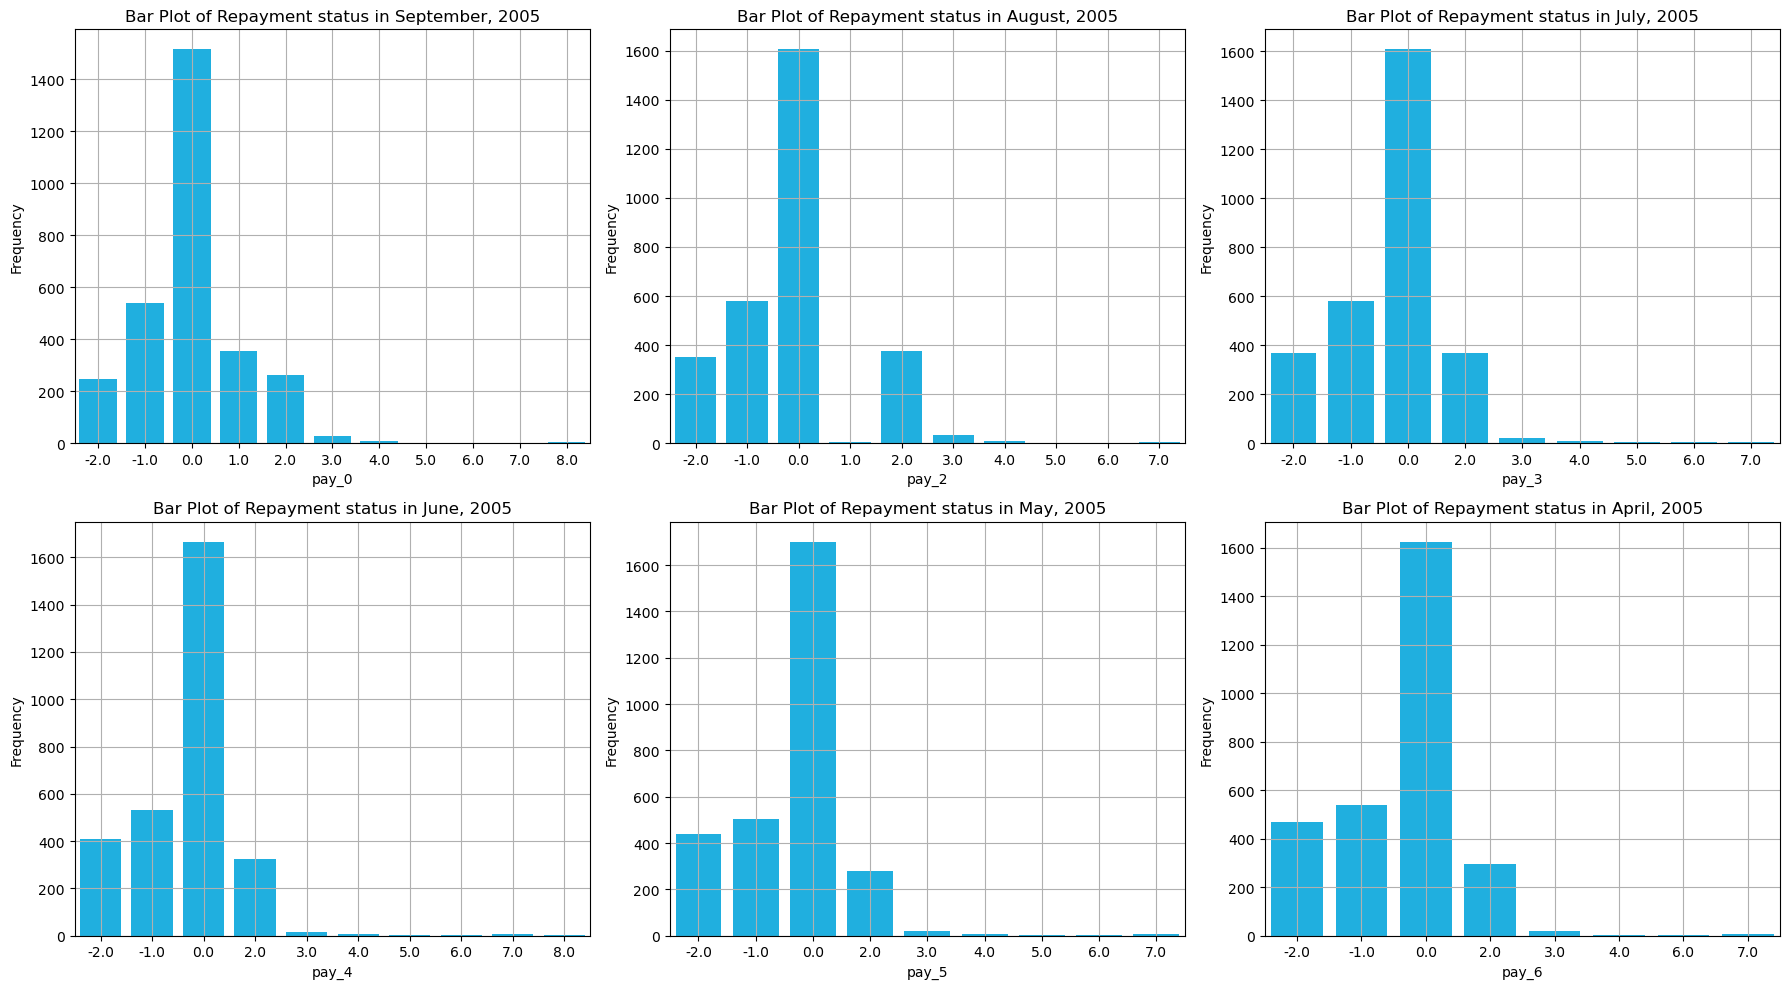

In [3200]:
# kolom dan nama kolom repayment status
pay_cols = ["pay_0", "pay_2", "pay_3", "pay_4", "pay_5", "pay_6"]
pay_col_names = ["Repayment status in September, 2005", "Repayment status in August, 2005", "Repayment status in July, 2005", "Repayment status in June, 2005", "Repayment status in May, 2005", "Repayment status in April, 2005"]

# figure
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# loop bar plot
for ax, col, col_name in zip(axes.flatten(), pay_cols, pay_col_names):
    sns.countplot(x=col, data=df_ori, color="deepskyblue", ax=ax)
    
    #label
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax.set_title(f"Bar Plot of {col_name}")
    ax.grid(True)

# show plot
plt.tight_layout()
plt.show()

insight:
- repayment dari bulan April hingga September 2005 didominasi oleh pembayaran tepat waktu atau kategori 0
- pada bulan September terlihat lebih banyak pemegang kartu kredit yang mengalami keterlambatan pembayaran dibandingkan dengan bulan-bulan sebelumnya

## 5.8. Bill Amount

In [3201]:
# bill_amt col group
bill_amt_cols = ["bill_amt_1", "bill_amt_2", "bill_amt_3", "bill_amt_4", "bill_amt_5", "bill_amt_6"]

# bill_amt_cols describe
df_ori[bill_amt_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
bill_amt_1,2965.0,52118.305228,72328.670541,-11545.0,3958.0,24257.0,69852.0,613860.0
bill_amt_2,2965.0,50649.153120,70785.001588,-67526.0,3390.0,23111.0,67827.0,512650.0
bill_amt_3,2965.0,48239.757504,68145.710745,-25443.0,3302.0,21520.0,63023.0,578971.0
bill_amt_4,2965.0,44089.683305,61907.454056,-46627.0,2582.0,19894.0,58622.0,488808.0
bill_amt_5,2965.0,40956.080607,58271.904751,-46627.0,1958.0,18814.0,53373.0,441981.0
bill_amt_6,2965.0,39773.072513,57303.488981,-73895.0,1430.0,18508.0,52287.0,436172.0


insight:
- rata-rata dan maksimum tagihan cenderung mengalami peningkatan dari bulan sebelumnya

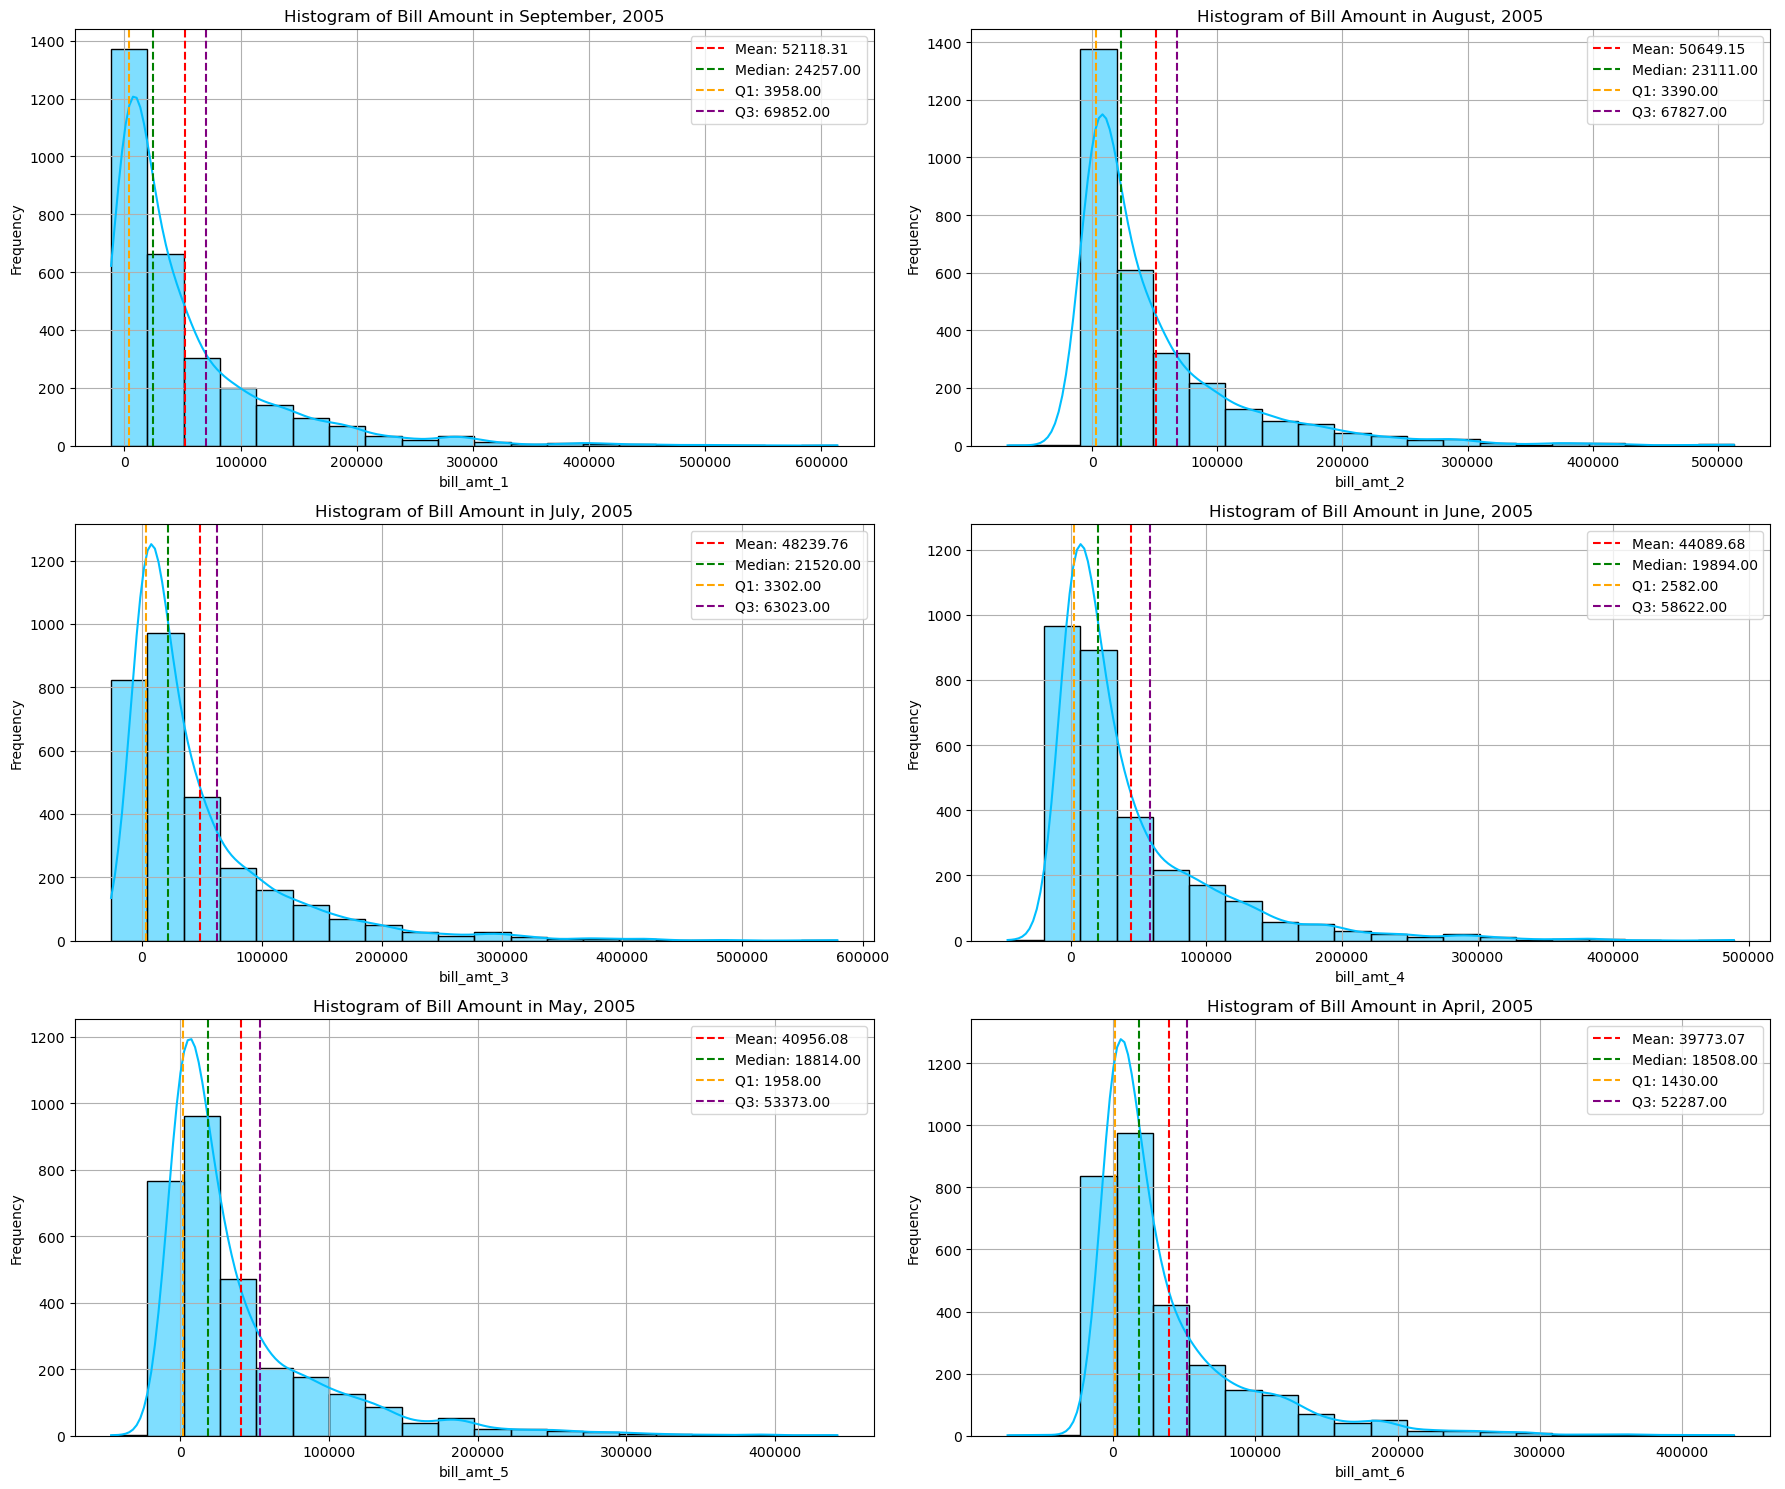

In [3202]:
# penamaan col bill_amt
bill_amt_col_names = ["Bill Amount in September, 2005", "Bill Amount in August, 2005", "Bill Amount in July, 2005", "Bill Amount in June, 2005", "Bill Amount in May, 2005", "Bill Amount in April, 2005"]

# figure
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 15))

# looping bill_amt
for ax, col, col_name in zip(axes.flatten(), bill_amt_cols, bill_amt_col_names):
    # plot histogram
    bins = 20
    sns.histplot(df_ori[col], bins=bins, kde=True, color="deepskyblue", ax=ax)

    # statistik
    mean_bill_amt = df_ori[col].mean()
    median_bill_amt = df_ori[col].median()
    q1_bill_amt = df_ori[col].quantile(0.25)
    q3_bill_amt = df_ori[col].quantile(0.75)

    # line mean, median, q1, q3
    ax.axvline(mean_bill_amt, color="red", linestyle="dashed", linewidth=1.5, label=f"Mean: {mean_bill_amt:.2f}")
    ax.axvline(median_bill_amt, color="green", linestyle="dashed", linewidth=1.5, label=f"Median: {median_bill_amt:.2f}")
    ax.axvline(q1_bill_amt, color="orange", linestyle="dashed", linewidth=1.5, label=f"Q1: {q1_bill_amt:.2f}")
    ax.axvline(q3_bill_amt, color="purple", linestyle="dashed", linewidth=1.5, label=f"Q3: {q3_bill_amt:.2f}")

    # label
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax.set_title(f"Histogram of {col_name}")
    ax.legend()
    ax.grid(True)

# show plot
plt.tight_layout()
plt.show()

insight:
- tagihan dari bulan April hingga September 2005 berfrekuensi tinggi pada range tagihan 0 hingga sekitar kurang dari 50,000 
- artinya kebanyakan pemegang kartu kredit memiliki tagihan dengan nominal yang terhitung kecil

## 5.9. Pay Ammount

In [3203]:
# pay_amt col group
pay_amt_cols = ["pay_amt_1", "pay_amt_2", "pay_amt_3", "pay_amt_4", "pay_amt_5", "pay_amt_6"]

# pay_amt_cols describe
df_ori[pay_amt_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
pay_amt_1,2965.0,6348.902867,20885.735336,0.0,1013.0,2234.0,5087.0,493358.0
pay_amt_2,2965.0,6272.494435,28879.674534,0.0,990.0,2175.0,5000.0,1227082.0
pay_amt_3,2965.0,5150.497133,14287.079982,0.0,477.0,1994.0,4500.0,199209.0
pay_amt_4,2965.0,4561.376054,13281.499599,0.0,313.0,1600.0,4000.0,202076.0
pay_amt_5,2965.0,4913.286678,16734.340778,0.0,323.0,1646.0,4021.0,388071.0
pay_amt_6,2965.0,5382.701518,17275.953029,0.0,173.0,1615.0,4081.0,403500.0


insight:
- rata-rata jumlah pembayaran tagihan meningkat pada pay_amt_1 (September 2005) dan pay_amt_2 (Agustus 2005) dibandingkan dengan bulan sebelumnya

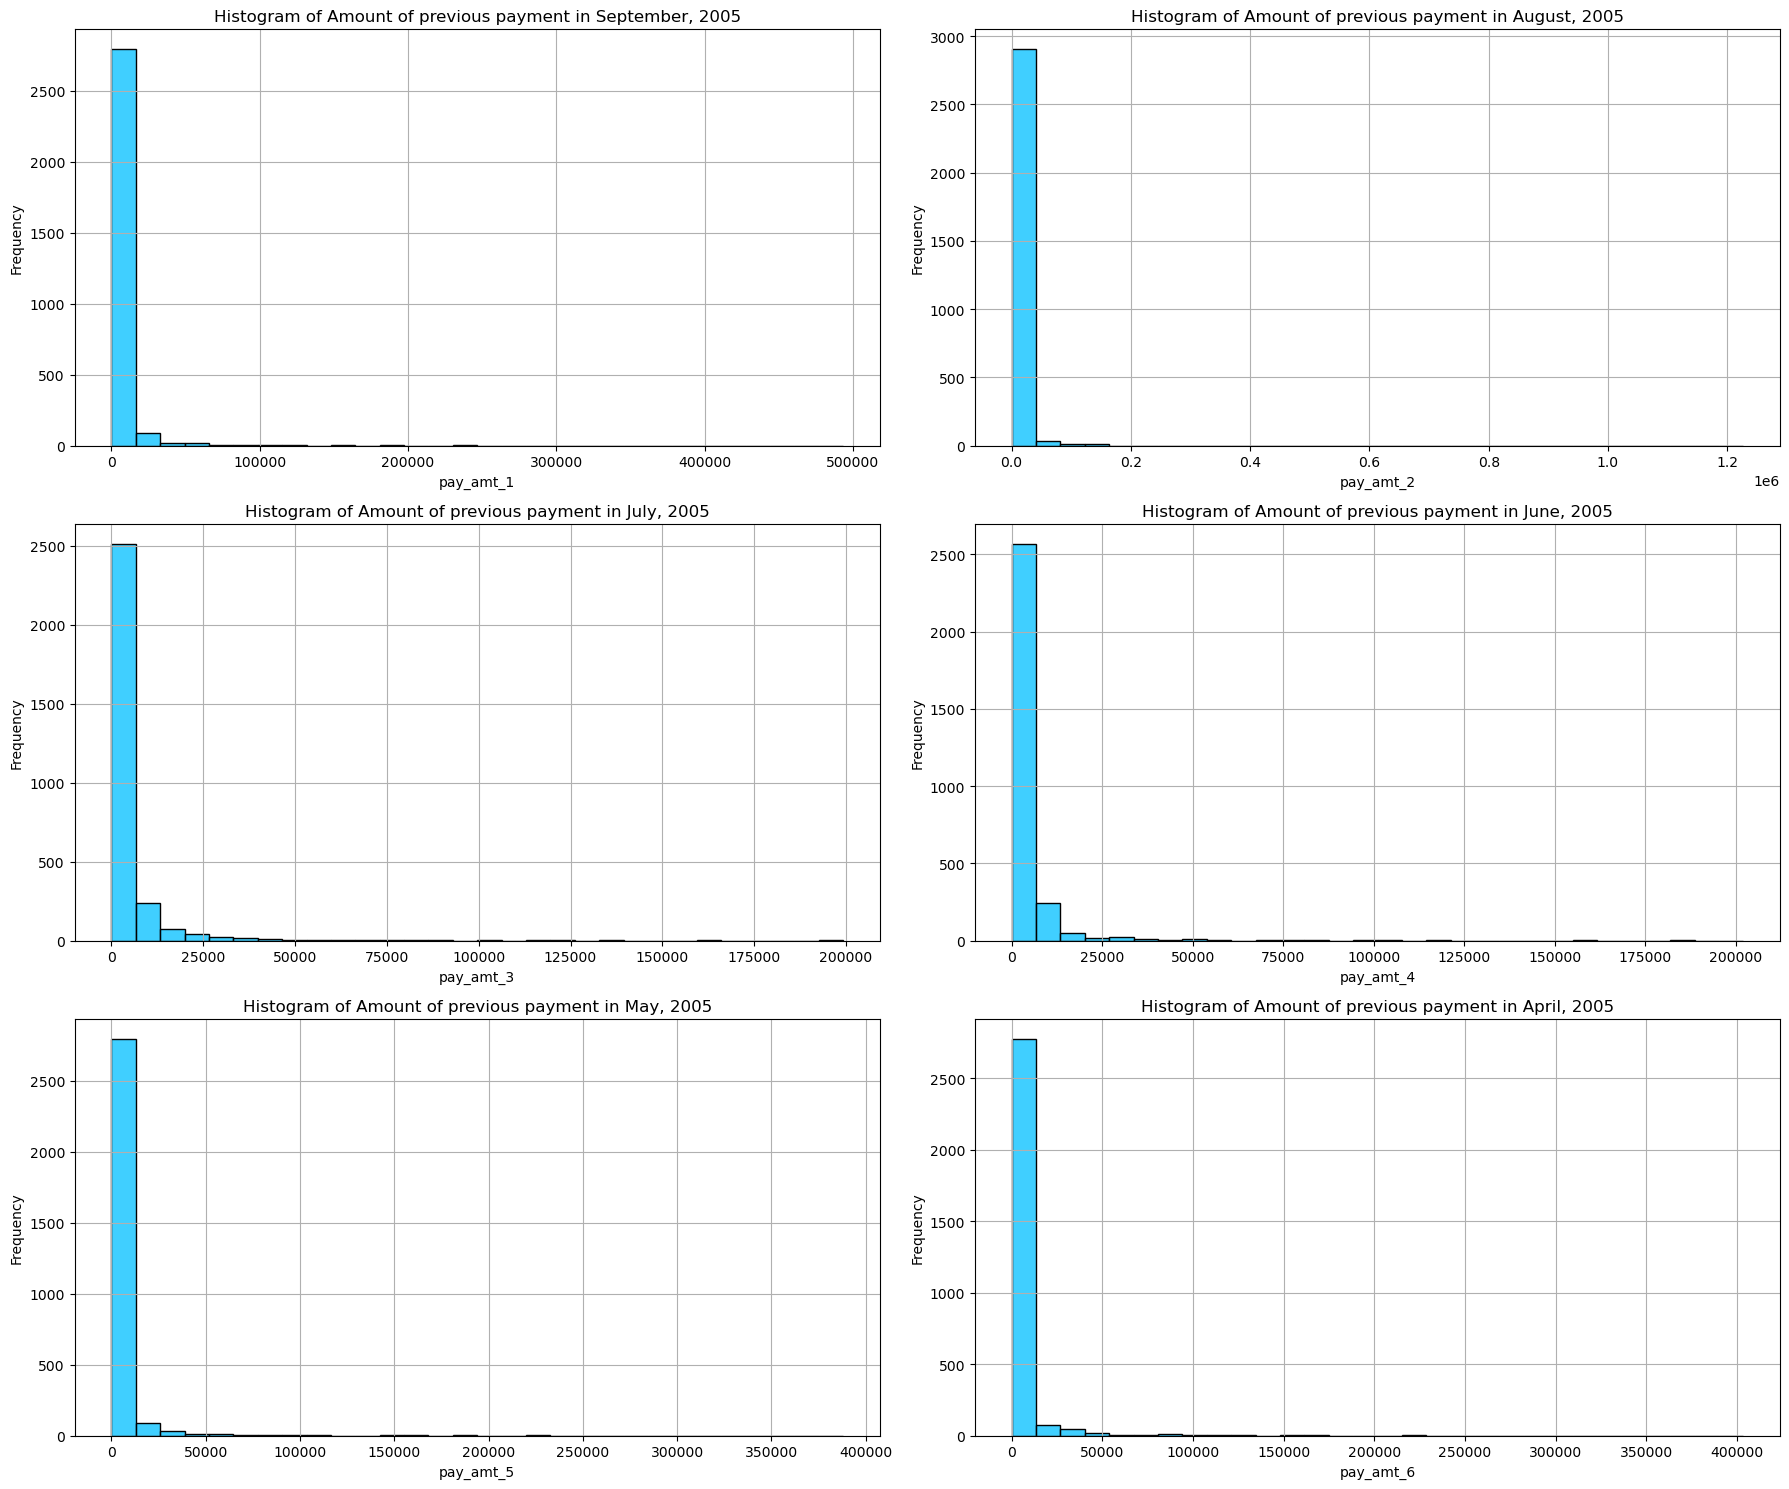

In [3204]:
# penamaan col pay_amt
pay_amt_col_names = ["Amount of previous payment in September, 2005", "Amount of previous payment in August, 2005", "Amount of previous payment in July, 2005", "Amount of previous payment in June, 2005", "Amount of previous payment in May, 2005", "Amount of previous payment in April, 2005"]

# figure
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 15))

# looping pay_amt
for ax, col, col_name in zip(axes.flatten(), pay_amt_cols, pay_amt_col_names):
    # plot histogram
    bins = 30
    sns.histplot(df_ori[col], bins=bins, color="deepskyblue", ax=ax)

    # label
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax.set_title(f"Histogram of {col_name}")
    ax.grid(True)

# show plot
plt.tight_layout()
plt.show()

insight:
- pembayaran tagihan dari bulan April hingga September 2005 berfrekuensi tinggi pada range tagihan 0 hingga sekitar kurang dari 25,000
- artinya pada setiap bulannya kebanyakan pemegang kartu kredit membayar tagihan dengan nominal yang terhitung kecil

## 5.10. Correlation

### 5.10.1. Numeric

In [3205]:
# numerik kolom
df_ori_num_col = ["default_payment_next_month", "limit_balance", "age", "bill_amt_1", "bill_amt_2", "bill_amt_3", "bill_amt_4", "bill_amt_5", "bill_amt_6", "pay_amt_1", "pay_amt_2", "pay_amt_3", "pay_amt_4", "pay_amt_5", "pay_amt_6"]

# korelasi kendal
corr_num_col = df_ori[df_ori_num_col]
df_corr_num_col = corr_num_col.corr(method="kendall")
df_corr_num_col

,default_payment_next_month,limit_balance,age,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
default_payment_next_month,1.000000,-0.144815,0.008207,-0.002947,0.005562,0.008840,0.014521,0.018755,0.023719,-0.119347,-0.119326,-0.097175,-0.098085,-0.071714,-0.113439
limit_balance,-0.144815,1.000000,0.133021,0.094986,0.094754,0.095791,0.098807,0.100683,0.102606,0.212857,0.210255,0.210348,0.217024,0.222757,0.232900
age,0.008207,0.133021,1.000000,0.013186,0.011788,0.005017,-0.005262,0.010047,0.015297,0.029388,0.015163,0.007755,0.033778,0.032086,0.016378
bill_amt_1,-0.002947,0.094986,0.013186,1.000000,0.818364,0.737280,0.670825,0.623647,0.584840,0.394548,0.359422,0.336522,0.336200,0.321032,0.287943
bill_amt_2,0.005562,0.094754,0.011788,0.818364,1.000000,0.808839,0.726742,0.670589,0.620998,0.506489,0.381674,0.361947,0.358776,0.340558,0.306192
bill_amt_3,0.008840,0.095791,0.005017,0.737280,0.808839,1.000000,0.799305,0.722328,0.663914,0.429374,0.500756,0.390491,0.386798,0.365711,0.341679
bill_amt_4,0.014521,0.098807,-0.005262,0.670825,0.726742,0.799305,1.000000,0.809727,0.732584,0.392727,0.420662,0.503909,0.406808,0.396753,0.363302
bill_amt_5,0.018755,0.100683,0.010047,0.623647,0.670589,0.722328,0.809727,1.000000,0.814655,0.372786,0.389655,0.430005,0.517898,0.417244,0.393777
bill_amt_6,0.023719,0.102606,0.015297,0.584840,0.620998,0.663914,0.732584,0.814655,1.000000,0.338674,0.359372,0.395677,0.454170,0.530582,0.405612
pay_amt_1,-0.119347,0.212857,0.029388,0.394548,0.506489,0.429374,0.392727,0.372786,0.338674,1.000000,0.400881,0.397142,0.390498,0.356803,0.336349


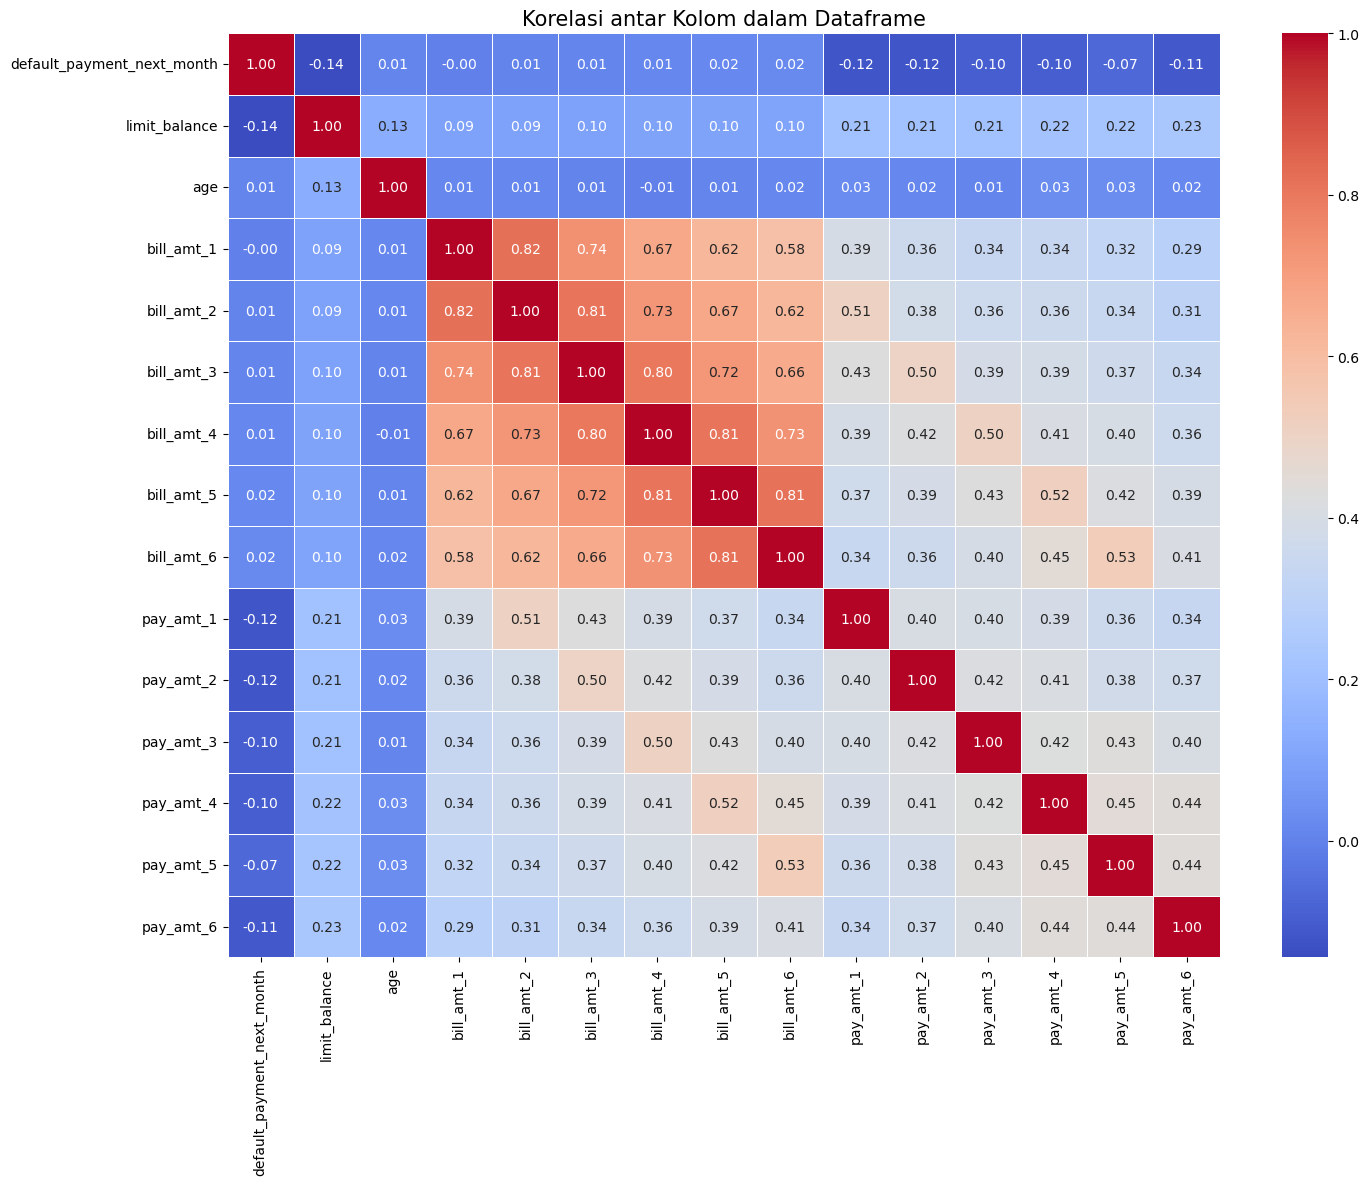

In [3206]:
# figure
plt.figure(figsize=(16, 12))
# heatmap
sns.heatmap(df_corr_num_col, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
# label
plt.title('Korelasi antar Kolom dalam Dataframe', fontsize=15)
# how plot
plt.show()

insight:
- default_payment_next_month memiliki korelasi negatif dengan limit_balance (-0.144815), menunjukkan bahwa semakin tinggi limit balance, semakin rendah kemungkinan default payment
- terdapat korelasi negatif dengan pay_amt_1 hingga pay_amt_6, yang menunjukkan bahwa semakin tinggi jumlah pembayaran, semakin rendah kemungkinan default payment
- Korelasi positif yang sangat kecil atau mendekati nol dengan kolom bill_amt_1 hingga bill_amt_6 menunjukkan bahwa jumlah tagihan bulanan tidak memiliki pengaruh besar terhadap default payment

### 5.10.2. Categoric

In [3207]:
# kolom kategorik 
df_ori_cat_col = ["default_payment_next_month","sex", "education_level", "marital_status", "pay_0", "pay_2", "pay_3", "pay_4", "pay_5", "pay_6"]
corr_cat_col = df_ori[df_ori_cat_col]

In [3208]:
# init chi_square_matrix
chi_square_matrix = pd.DataFrame(index=corr_cat_col.columns, columns=corr_cat_col.columns)
chi_square_matrix

# loop chi-square
for col1 in corr_cat_col.columns:
    for col2 in corr_cat_col.columns:
        if col1 != col2:
            contingency_table = pd.crosstab(corr_cat_col[col1], corr_cat_col[col2])
            chi2, p, dof, ex = chi2_contingency(contingency_table)
            chi_square_matrix.loc[col1, col2] = p
        else:
            chi_square_matrix.loc[col1, col2] = np.nan

chi_square_matrix = chi_square_matrix.astype(float)
chi_square_matrix

,default_payment_next_month,sex,education_level,marital_status,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6
default_payment_next_month,NaN,0.254588,2.776981e-05,3.221207e-01,1.675583e-131,5.263374e-79,1.905253e-68,4.726862e-61,1.608671e-60,1.068347e-51
sex,2.545876e-01,NaN,8.330853e-02,8.302908e-01,9.386555e-03,5.127138e-05,9.731543e-06,3.209648e-03,6.535006e-02,3.805765e-02
education_level,2.776981e-05,0.083309,NaN,4.519476e-20,5.855293e-07,1.427671e-08,4.495833e-11,4.704255e-07,1.035817e-06,1.048168e-06
marital_status,3.221207e-01,0.830291,4.519476e-20,NaN,5.881089e-01,2.845465e-01,7.785609e-01,6.297317e-01,5.214730e-01,1.602094e-01
pay_0,1.675583e-131,0.009387,5.855293e-07,5.881089e-01,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
pay_2,5.263374e-79,0.000051,1.427671e-08,2.845465e-01,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
pay_3,1.905253e-68,0.000010,4.495833e-11,7.785609e-01,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00
pay_4,4.726862e-61,0.003210,4.704255e-07,6.297317e-01,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00
pay_5,1.608671e-60,0.065350,1.035817e-06,5.214730e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00
pay_6,1.068347e-51,0.038058,1.048168e-06,1.602094e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN


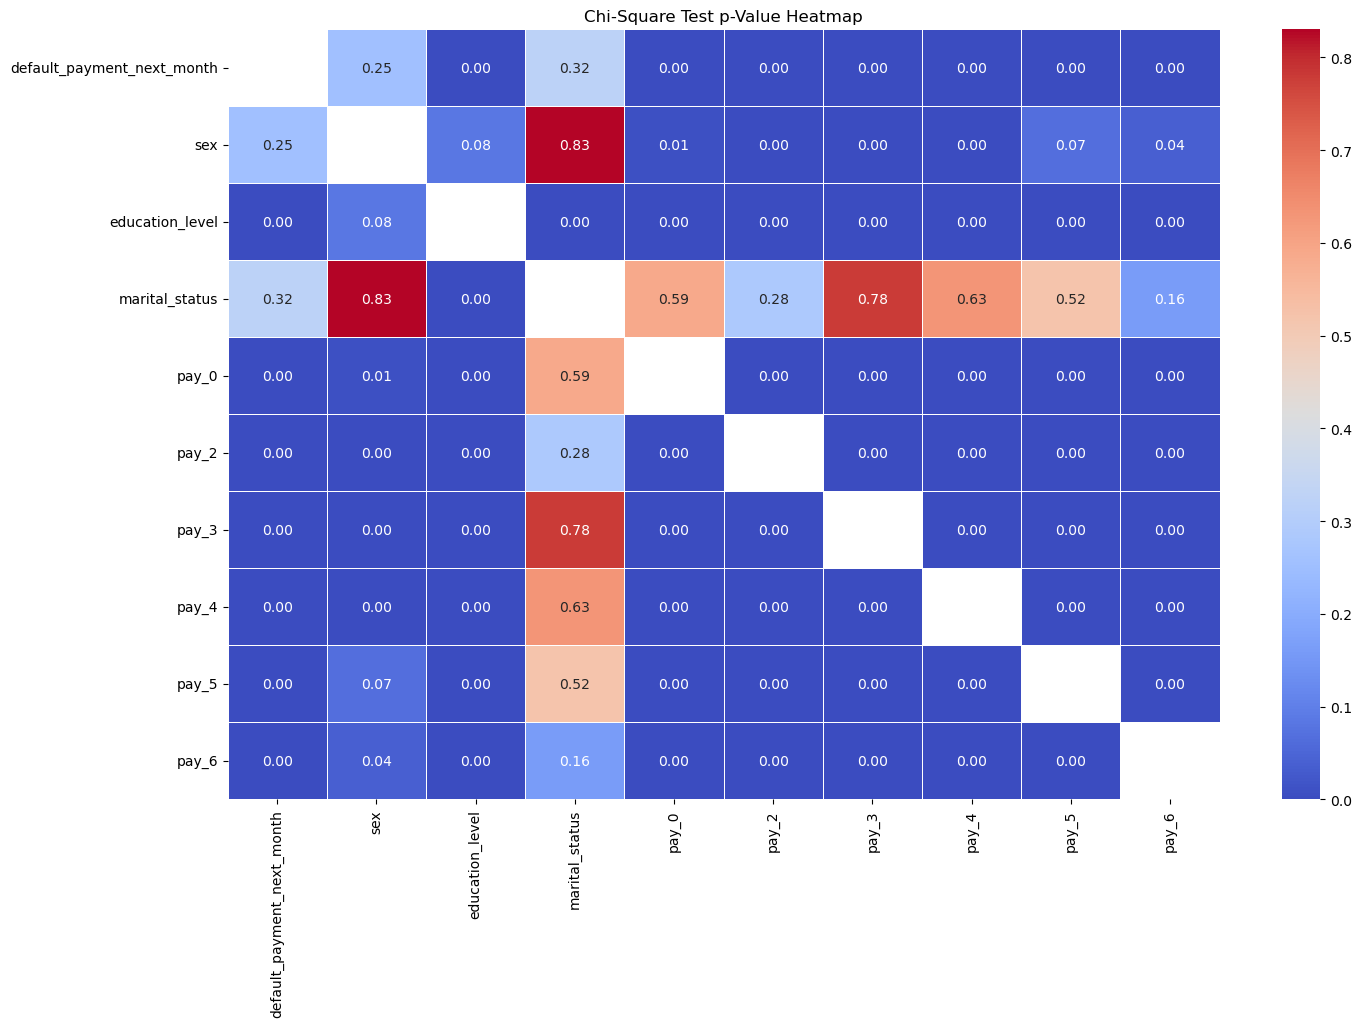

In [3209]:
# plot heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(chi_square_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Chi-Square Test p-Value Heatmap')
plt.show()

insight:
- default_payment_next_month memiliki nilai p-value yang sangat kecil (< 0.05) kolom education_level dan pay_0 hingga pay_6, yang menunjukkan bahwa ada hubungan nyata antara status pembayaran bulanan dan default payment

## 5.11. EDA Conclusion

kolom yang memiliki korelasi signifikan terhadap default_payment_next_month terdiri dari:
- limit_balance
- education_level
- pay_0 sampai pay_6
- pay_amt_1 sampai pay_amt_6

# 6. Feature Engineering

## 6.1. Feature Selection

In [3210]:
# show df_ori column
df_ori.columns

Index(['limit_balance', 'sex', 'education_level', 'marital_status', 'age',
       'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt_1',
       'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6',
       'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5',
       'pay_amt_6', 'default_payment_next_month'],
      dtype='object')

Berdasarkan hasil EDA maka feature yang digunakan adalah:
1. limit_balance
2. education_level
3. pay_0
4. pay_2
5. pay_3
6. pay_4
7. pay_5
8. pay_6
9. pay_amt_1
10. pay_amt_2
11. pay_amt_3
12. pay_amt_4
13. pay_amt_5
14. pay_amt_6

In [3211]:
# select column feature
feature_cols = ["default_payment_next_month", "limit_balance", "education_level", "pay_0", "pay_2", "pay_3", "pay_4", "pay_5", "pay_6", "pay_amt_1", "pay_amt_2", "pay_amt_3", "pay_amt_4", "pay_amt_5", "pay_amt_6"]

# dataframe untuk model named df_model
df_model = df_ori[feature_cols]
df_model

,default_payment_next_month,limit_balance,education_level,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
0,1,80000.0,6,0.0,0.0,0.0,0.0,0.0,0.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0
1,0,200000.0,4,0.0,0.0,0.0,0.0,0.0,0.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0
2,1,20000.0,6,0.0,0.0,0.0,0.0,0.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0
3,0,260000.0,4,0.0,0.0,0.0,0.0,0.0,0.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0
4,0,150000.0,4,0.0,0.0,0.0,-1.0,0.0,0.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2960,0,80000.0,3,-1.0,-1.0,-1.0,-2.0,-2.0,-2.0,2800.0,0.0,0.0,0.0,0.0,0.0
2961,1,50000.0,3,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,300.0,5880.0,0.0,0.0,0.0,0.0
2962,1,450000.0,2,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,390.0,780.0,390.0,390.0,390.0,390.0
2963,0,50000.0,2,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,390.0,390.0,390.0,390.0,0.0,780.0


## 6.2. Split Features (X) and Target (Y)

In [3212]:
# feature
X = df_model.drop("default_payment_next_month", axis=1)

# target
y = df_model["default_payment_next_month"]

In [3213]:
# shape feature
print("feature  :", X.shape)
# shape target
print("target   :", y.shape)

feature  : (2965, 14)
target   : (2965,)


In [3214]:
# show feature
X

,limit_balance,education_level,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
0,80000.0,6,0.0,0.0,0.0,0.0,0.0,0.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0
1,200000.0,4,0.0,0.0,0.0,0.0,0.0,0.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0
2,20000.0,6,0.0,0.0,0.0,0.0,0.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0
3,260000.0,4,0.0,0.0,0.0,0.0,0.0,0.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0
4,150000.0,4,0.0,0.0,0.0,-1.0,0.0,0.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2960,80000.0,3,-1.0,-1.0,-1.0,-2.0,-2.0,-2.0,2800.0,0.0,0.0,0.0,0.0,0.0
2961,50000.0,3,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,300.0,5880.0,0.0,0.0,0.0,0.0
2962,450000.0,2,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,390.0,780.0,390.0,390.0,390.0,390.0
2963,50000.0,2,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,390.0,390.0,390.0,390.0,0.0,780.0


In [3215]:
# show target
y

0       1
1       0
2       1
3       0
4       0
       ..
2960    0
2961    1
2962    1
2963    0
2964    0
Name: default_payment_next_month, Length: 2965, dtype: int64

## 6.3. Split Train and Test Set

In [3216]:
# split train and test set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=31)

# show X_train
X_train

,limit_balance,education_level,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
2774,260000.0,1,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,0.0,0.0,0.0,1150.0,0.0
1954,30000.0,2,2.0,2.0,3.0,3.0,2.0,2.0,2700.0,1500.0,0.0,1100.0,1000.0,0.0
2069,80000.0,2,0.0,0.0,0.0,-1.0,-1.0,-1.0,10000.0,10000.0,4849.0,4849.0,4849.0,4849.0
1384,10000.0,2,0.0,0.0,2.0,0.0,0.0,0.0,3507.0,0.0,500.0,370.0,393.0,700.0
2294,240000.0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,548.0,208.0,0.0,44.0,0.0,643.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826,210000.0,2,0.0,0.0,0.0,0.0,0.0,0.0,4534.0,3000.0,1000.0,2000.0,2230.0,1026.0
2658,320000.0,2,-1.0,-1.0,-2.0,-2.0,-2.0,-2.0,28791.0,13227.0,2621.0,9075.0,6564.0,12767.0
2942,430000.0,2,1.0,-1.0,-1.0,-2.0,-2.0,-2.0,2500.0,0.0,0.0,0.0,0.0,0.0
2064,460000.0,2,0.0,0.0,0.0,-1.0,-1.0,-1.0,1335.0,10000.0,3316.0,3316.0,3316.0,3316.0


In [3217]:
# show X_test
X_test

,limit_balance,education_level,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
1338,20000.0,1,0.0,0.0,2.0,0.0,0.0,0.0,3170.0,0.0,1000.0,1000.0,3000.0,0.0
1124,20000.0,3,0.0,0.0,0.0,0.0,0.0,0.0,1280.0,1304.0,1316.0,754.0,931.0,463.0
2504,210000.0,3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,390.0,390.0,4962.0,0.0,780.0,6668.0
1414,100000.0,2,2.0,2.0,2.0,0.0,0.0,0.0,1300.0,0.0,700.0,700.0,700.0,800.0
1484,70000.0,3,3.0,2.0,2.0,0.0,0.0,0.0,1200.0,0.0,1482.0,1000.0,426.0,1000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1207,320000.0,3,0.0,0.0,0.0,0.0,0.0,0.0,3084.0,3007.0,3031.0,2367.0,2450.0,2432.0
909,220000.0,2,0.0,0.0,0.0,0.0,0.0,0.0,10000.0,6500.0,5000.0,5000.0,5000.0,5000.0
1083,180000.0,2,1.0,2.0,0.0,0.0,0.0,2.0,0.0,1590.0,638.0,1628.0,0.0,834.0
131,80000.0,1,0.0,0.0,0.0,0.0,0.0,0.0,4369.0,3343.0,3137.0,2914.0,3151.0,3320.0


In [3218]:
# show y_train
y_train

2774    1
1954    1
2069    0
1384    1
2294    1
       ..
826     0
2658    0
2942    1
2064    0
722     0
Name: default_payment_next_month, Length: 2372, dtype: int64

In [3219]:
# show y_test
y_test

1338    0
1124    1
2504    1
1414    1
1484    0
       ..
1207    0
909     0
1083    0
131     0
2919    0
Name: default_payment_next_month, Length: 593, dtype: int64

In [3220]:
# cek shape
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2372, 14)
(2372,)
(593, 14)
(593,)


## 6.4. Handling Outliers

### 6.4.1. Limit Balance

In [3221]:
# skewness X_train_limit_balance
skew_X_train_limit_balance = X_train["limit_balance"].skew()
print(f"skewness X_train_limit_balance       = {skew_X_train_limit_balance}")

# quantile X_train_limit_balance
q1_X_train_limit_balance = X_train["limit_balance"].quantile(0.25)
q3_X_train_limit_balance = X_train["limit_balance"].quantile(0.75)
iqr_X_train_limit_balance = q3_X_train_limit_balance - q1_X_train_limit_balance

# upper and lower boundary limit_balance skew
ub_X_train_limit_balance = q3_X_train_limit_balance + 1.5 * iqr_X_train_limit_balance
lb_X_train_limit_balance = q1_X_train_limit_balance - 1.5 * iqr_X_train_limit_balance

print(f"upper boundary X_train_limit_balance = {ub_X_train_limit_balance}")
print(f"lower boundary X_train_limit_balance = {lb_X_train_limit_balance}")
print("")

# outliers
outlier_limit_balance = X_train["limit_balance"][(X_train["limit_balance"]<lb_X_train_limit_balance) | (X_train["limit_balance"]>ub_X_train_limit_balance)]

if len(outlier_limit_balance) > 0:
    print(f"terdapat outliers sebanyak {len(outlier_limit_balance)} row")
    print(f"dengan persentase {(len(outlier_limit_balance) / len(X_train['limit_balance']) * 100):.2f}%")
    print("")

    # min, max outlier_limit_balance
    min_outlier_limit_balance = outlier_limit_balance.min()
    max_outlier_limit_balance = outlier_limit_balance.max()
    print(f"min outlier_limit_balance = {min_outlier_limit_balance}")
    print(f"max outlier_limit_balance = {max_outlier_limit_balance}")

else:
    print("tidak ada outliers")

skewness X_train_limit_balance       = 0.9831755421744205
upper boundary X_train_limit_balance = 500000.0
lower boundary X_train_limit_balance = -220000.0

terdapat outliers sebanyak 12 row
dengan persentase 0.51%

min outlier_limit_balance = 510000.0
max outlier_limit_balance = 780000.0


insight:
- terdapat outliers di limit_balance
- akan dilakukan drop outliers

In [3222]:
# drop limit_balance outliers
X_train = X_train.drop(outlier_limit_balance.index)
y_train = y_train.drop(outlier_limit_balance.index)

In [3223]:
# cek shape setelah drop
print(X_train.shape)
print(y_train.shape)

(2360, 14)
(2360,)


### 6.4.2. Payment Ammount

In [3224]:
columns_to_check = ["pay_amt_1", "pay_amt_2", "pay_amt_3", "pay_amt_4", "pay_amt_5", "pay_amt_6"]

for col in columns_to_check:
    # skewness
    skew_col = X_train[col].skew()
    print(f"skewness {col}       = {skew_col}")

    # q1 q3 iqr
    q1_col = X_train[col].quantile(0.25)
    q3_col = X_train[col].quantile(0.75)
    iqr_col = q3_col - q1_col

    # lower upper boundary
    ub_col = q3_col + 1.5 * iqr_col
    lb_col = q1_col - 1.5 * iqr_col

    print(f"upper boundary {col} = {ub_col}")
    print(f"lower boundary {col} = {lb_col}")

    # outliers
    outlier_col = X_train[col][(X_train[col] < lb_col) | (X_train[col] > ub_col)]

    if len(outlier_col) > 0:
        print(f"terdapat outliers sebanyak {len(outlier_col)} row")
        print(f"dengan persentase {(len(outlier_col) / len(X_train[col]) * 100):.2f}%")

        # min max outliers
        min_outlier_col = outlier_col.min()
        max_outlier_col = outlier_col.max()
        print(f"min outlier_{col} = {min_outlier_col}")
        print(f"max outlier_{col} = {max_outlier_col}")
    else:
        print(f"tidak ada outliers untuk kolom {col}")

    print("")


skewness pay_amt_1       = 9.251453133188118
upper boundary pay_amt_1 = 11073.125
lower boundary pay_amt_1 = -5043.875
terdapat outliers sebanyak 227 row
dengan persentase 9.62%
min outlier_pay_amt_1 = 11075.0
max outlier_pay_amt_1 = 260000.0

skewness pay_amt_2       = 15.99013967801664
upper boundary pay_amt_2 = 11015.0
lower boundary pay_amt_2 = -5025.0
terdapat outliers sebanyak 228 row
dengan persentase 9.66%
min outlier_pay_amt_2 = 11019.0
max outlier_pay_amt_2 = 580464.0

skewness pay_amt_3       = 7.9579553785629935
upper boundary pay_amt_3 = 10534.875
lower boundary pay_amt_3 = -5558.125
terdapat outliers sebanyak 206 row
dengan persentase 8.73%
min outlier_pay_amt_3 = 10549.0
max outlier_pay_amt_3 = 199209.0

skewness pay_amt_4       = 8.360531794680826
upper boundary pay_amt_4 = 9528.875
lower boundary pay_amt_4 = -5212.125
terdapat outliers sebanyak 221 row
dengan persentase 9.36%
min outlier_pay_amt_4 = 9570.0
max outlier_pay_amt_4 = 202076.0

skewness pay_amt_5       = 11

insight:
- ditemukan outliers pada pay_amt_1 hingga pay_amt_6 namun tidak akan dilakukan handling outliers untuk menjaga jumlah row karena jika dilakukan drop kemungkinan setidaknya akan menghilangkan 8% atau sekitar 200 row dari total data

## 6.5. Handling Missing Value

In [3225]:
# cek value education_level
X_train["education_level"].value_counts()

education_level
2    1100
1     830
3     395
5      21
4       8
6       4
0       2
Name: count, dtype: int64

insight:
- ditemukan value 0 pada education_level namun tidak akan dilakukan handling missing value

## 6.6. Split Categorical and Numerical

In [3226]:
# check shape
print(X_train.shape)
print(y_train.shape)

(2360, 14)
(2360,)


In [3227]:
# kolom numerikal 
num_col = ["limit_balance", "pay_amt_1", "pay_amt_2", "pay_amt_3", "pay_amt_4", "pay_amt_5", "pay_amt_6"]

# kolom kategorik ordinal
cat_col_o = ["pay_0", "pay_2", "pay_3", "pay_4", "pay_5", "pay_6"]

# kolom kategorik nominal
cat_col_n = ["education_level"]

In [3228]:
# X_train dan X_test numerikal
X_train_num = X_train[num_col]
X_test_num = X_test[num_col]

# X_train dan X_test kategorik ordinal
X_train_cat_o = X_train[cat_col_o]
X_test_cat_o = X_test[cat_col_o]

# X_train dan X_test kategorik nominal
X_train_cat_n = X_train[cat_col_n]
X_test_cat_n = X_test[cat_col_n]

In [3229]:
# check shape
print(X_train_num.shape)
print(X_train_cat_o.shape)
print(X_train_cat_n.shape)
print(y_train.shape)


(2360, 7)
(2360, 6)
(2360, 1)
(2360,)


## 6.7. Feature Scaling

In [3230]:
# init dan fitting MinMaxScaler X_train_num
scaler = MinMaxScaler()
scaler.fit(X_train_num)

MinMaxScaler()

In [3231]:
# scaling X_train_num dan X_test_num
X_train_num_scaled = scaler.transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

In [3232]:
# cek shape
print(X_train_num_scaled.shape)
print(y_train.shape)

(2360, 7)
(2360,)


## 6.8. Feature Encoding

### 6.8.1. Ordinal

In [3233]:
# cek cardinality
X_train_cat_o.nunique()

pay_0    11
pay_2    10
pay_3     9
pay_4    10
pay_5     9
pay_6     8
dtype: int64

insight:
- kolom repayment status memiliki cardinality yang tinggi
- kemungkinan akan mempengaruhi prediksi model karena menangani banyak kategori pada feature

In [3234]:
# unique value setiap column pay_
for col in X_train_cat_o.columns:
    unique_vals = sorted(X_train_cat_o[col].unique())
    print(f"Unique values {col} : {unique_vals}")

Unique values pay_0 : [-2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
Unique values pay_2 : [-2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
Unique values pay_3 : [-2.0, -1.0, 0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
Unique values pay_4 : [-2.0, -1.0, 0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
Unique values pay_5 : [-2.0, -1.0, 0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
Unique values pay_6 : [-2.0, -1.0, 0.0, 2.0, 3.0, 4.0, 6.0, 7.0]


In [3235]:
# init dan fitting X_train_cat_o dengan OrdinalEncoder
encoder_o = OrdinalEncoder(categories=[[-2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]] * X_train_cat_o.shape[1])
encoder_o.fit(X_train_cat_o)

OrdinalEncoder(categories=[[-2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0,
                            8.0],
                           [-2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0,
                            8.0],
                           [-2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0,
                            8.0],
                           [-2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0,
                            8.0],
                           [-2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0,
                            8.0],
                           [-2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0,
                            8.0]])

In [3236]:
# encode X_train_cat_o dan X_test_cat_o
X_train_encoded_o = encoder_o.transform(X_train_cat_o)
X_test_encoded_o = encoder_o.transform(X_test_cat_o)

In [3237]:
# check shape
print(X_train_encoded_o.shape)
print(X_test_encoded_o.shape)

(2360, 6)
(593, 6)


### 6.8.2. Nominal

In [3238]:
# cek cardinality
X_train_cat_n.nunique()

education_level    7
dtype: int64

insight:
- education_level meliki cardinality yang tinggi
- kemungkinan akan mempengaruhi prediksi model karena menangani banyak kategori pada feature

In [3239]:
# init dan fitting X_train_cat_n dengan OneHotEncoder
encoder_n = OneHotEncoder()
encoder_n.fit(X_train_cat_n)

OneHotEncoder()

In [3240]:
# encode X_train_cat_n dan X_test_cat_n
X_train_encoded_n = encoder_n.transform(X_train_cat_n).toarray()
X_test_encoded_n = encoder_n.transform(X_test_cat_n).toarray()

In [3241]:
# check shape
print(X_train_encoded_n.shape)
print(X_test_encoded_n.shape)

(2360, 7)
(593, 7)


## 6.9. Merge (Concat) Data

In [3242]:
# menggabungkan X_train_num_scaled, X_train_encoded_o dan X_train_encoded_n
X_train_final = np.concatenate(
    [X_train_num_scaled, X_train_encoded_o, X_train_encoded_n], axis=1
)

# menggabungkan X_test_num_scaled, X_test_encoded_o dan X_test_encoded_n
X_test_final = np.concatenate(
    [X_test_num_scaled, X_test_encoded_o, X_test_encoded_n], axis=1
)

In [3243]:
# check shape
print(X_train_final.shape)
print(y_train.shape)

(2360, 20)
(2360,)


# 7. Model Definition

Model yang akan digunakan kali ini adalah Logistic Regression, K-Nearest Neighbors (KNN) dan Support Vector machine (SVM)

In [3244]:
# model logistic regression
model_logreg = LogisticRegression()

# model knn
model_knn = KNeighborsClassifier()

# model svm
model_svm = SVC()

# 8. Model Training

In [3245]:
# train model_logreg X_train_final dan y_train
model_logreg.fit(X_train_final, y_train)

# train model_knn X_train_final dan y_train
model_knn.fit(X_train_final, y_train)

# train model_svm X_train_final dan y_train
model_svm.fit(X_train_final, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SVC()

# 9. Model Evaluation

Matriks yang digunakan untuk model evaluasi adalah Accuracy, Precision, Recall dan F1 Score.

Matriks Accuracy digunakan untuk melihat proporsi akurasi seberapa sering model membuat prediksi yang benar secara keseluruhan dan sebagai pembanding bagi matriks selanjutnya.

Matriks Precision digunakan untuk melihat proporsi false positif dalam hal ini untuk melihat prediksi yang dianggap gagal bayar tetapi sebenarnya tidak gagal bayar. Precision memberikan informasi tentang kualitas dari prediksi positif yang dibuat oleh model.

Matriks Recall digunakan untuk melihat proporsi false negatif dalam hal ini untuk melihat prediksi yang dianggap tidak gagal bayar tetapi sebenarnya gagal bayar. Recall memberikan informasi tentang seberapa baik model dalam menangkap semua kasus positif sebenarnya.

Matriks F1 Score digunakan untuk melihat rata-rata dari Precision dan Recall yang bisa juga digunakan sebagai metrik untuk menyeimbangkan antara Precision dan Recall.

## 9.1. Baseline

In [3246]:
# prediksi model_logreg
y_pred_train_model_logreg = model_logreg.predict(X_train_final)
y_pred_test_model_logreg = model_logreg.predict(X_test_final)

# prediksi model_knn
y_pred_train_model_knn = model_knn.predict(X_train_final)
y_pred_test_model_knn = model_knn.predict(X_test_final)

# prediksi model_svm
y_pred_train_model_svm = model_svm.predict(X_train_final)
y_pred_test_model_svm = model_svm.predict(X_test_final)

In [3247]:
# classification_report logres
print("Evaluation Logistic Regression")
print("Train\n", classification_report(y_train, y_pred_train_model_logreg))
print("Test\n", classification_report(y_test, y_pred_test_model_logreg))
print("")

# classification_report knn
print("Evaluation KNN")
print("Train\n", classification_report(y_train, y_pred_train_model_knn))
print("Test\n", classification_report(y_test, y_pred_test_model_knn))
print("")

# classification_report svm
print("Evaluation SVM")
print("Train\n", classification_report(y_train, y_pred_train_model_svm))
print("Test\n", classification_report(y_test, y_pred_test_model_svm))

Evaluation Logistic Regression
Train
               precision    recall  f1-score   support

           0       0.83      0.98      0.90      1850
           1       0.77      0.27      0.40       510

    accuracy                           0.82      2360
   macro avg       0.80      0.62      0.65      2360
weighted avg       0.82      0.82      0.79      2360

Test
               precision    recall  f1-score   support

           0       0.84      0.97      0.90       468
           1       0.76      0.30      0.43       125

    accuracy                           0.83       593
   macro avg       0.80      0.64      0.67       593
weighted avg       0.82      0.83      0.80       593


Evaluation KNN
Train
               precision    recall  f1-score   support

           0       0.87      0.95      0.91      1850
           1       0.72      0.51      0.59       510

    accuracy                           0.85      2360
   macro avg       0.80      0.73      0.75      2360
weighte

insight:
1. Logistic Regression

Logistic Regression menunjukkan kinerja yang baik pada kelas mayoritas (kelas 0) dengan akurasi dan precision yang tinggi, tetapi mengalami kesulitan pada kelas minoritas (kelas 1) dengan recall dan F1-score yang rendah. Ini menunjukkan bahwa model memiliki kecenderungan untuk memprediksi kelas mayoritas lebih sering daripada kelas minoritas.

2. KNN

KNN juga menunjukkan hasil yang lebih baik pada kelas mayoritas (kelas 0) dibandingkan kelas minoritas (kelas 1). Meskipun precision dan recall untuk kelas minoritas lebih tinggi dibandingkan dengan Logistic Regression, hasil keseluruhan tetap lebih baik pada kelas mayoritas.

3. SVM

SVM menunjukkan kinerja yang konsisten baik pada train maupun test set. Meskipun kinerja pada kelas minoritas masih lebih rendah dibandingkan dengan kelas mayoritas, SVM menunjukkan hasil yang lebih seimbang dibandingkan Logistic Regression dan KNN.

Confusion Matrix Logistic Regression : 


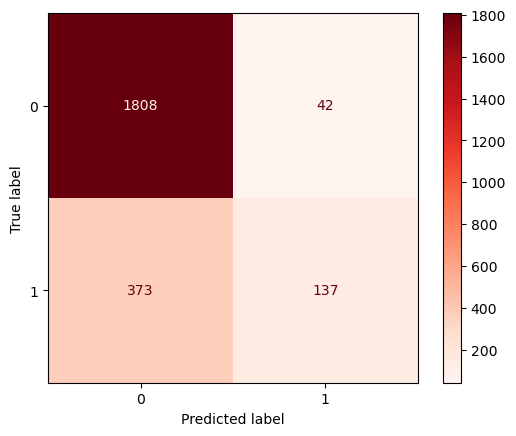

In [3248]:
# Confusion Matrix Logistic Regression
print('Confusion Matrix Logistic Regression : \n', ConfusionMatrixDisplay.from_estimator(model_logreg, X_train_final, y_train, cmap='Reds'))

insight:
- model menunjukan kinerja yang baik dalam memprediksi kategori 0 namun kurang optimal dalam memprediksi kategori 1, ditunjukan dengan masih banyaknya false negatif (373) dibandingkan true negatif (137)

Confusion Matrix KNN: 


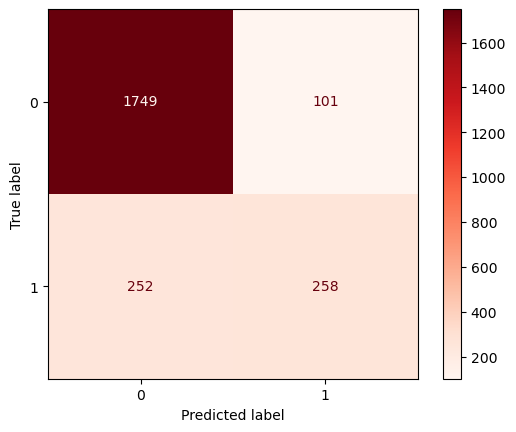

In [3249]:
# Confusion Matrix KNN
print('Confusion Matrix KNN: \n', ConfusionMatrixDisplay.from_estimator(model_knn, X_train_final, y_train, cmap='Reds'))

insight:
- model menunjukan kinerja yang baik dalam memprediksi kategori 0 namun kurang optimal dalam memprediksi kategori 1
- dalam memprediksi kategori 1 model KNN ini lebih optimal dibandingkan dengan Logistic Regression

Confusion Matrix SVM: 


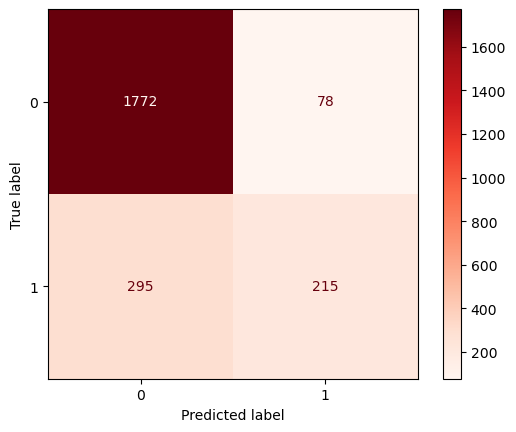

In [3250]:
# Confusion Matrix SVM
print('Confusion Matrix SVM: \n', ConfusionMatrixDisplay.from_estimator(model_svm, X_train_final, y_train, cmap='Reds'))

insight:
- model menunjukan kinerja yang baik dalam memprediksi kategori 0 namun kurang optimal dalam memprediksi kategori 0
- dibandingkan dengan model Logistic Regression dan KNN sebelumnya, model SVM ini menunjukan performa yang lebiih seimbang dalam memprediksi kategori 0 dan 1

## 9.2. Hyperparameter Tuning

In [3251]:
# Logistic Regression hyperparameter tunning
param_grid_logreg = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300],
    'class_weight': [None, 'balanced'],
}

# init gridsearch logreg
grid_logreg = GridSearchCV(model_logreg, param_grid_logreg, cv=5, verbose=1)

In [3252]:
# KNN hyperparameter tunning
param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree'],
    'leaf_size': [30, 50, 100],
    'p': [1, 2]
}

# init gridsearch knn
grid_knn = GridSearchCV(model_knn, param_grid_knn, cv=5, verbose=1)

In [3253]:
# SVM hyperparameter tunning
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'max_iter': [1000, 2000, 3000],
    'class_weight': [None, 'balanced'],
}

# init gridsearch svm
grid_svm = GridSearchCV(model_svm, param_grid_svm, cv=5, verbose=1)

In [3254]:
# train menggunakan gridsearch logreg
grid_logreg.fit(X_train_final, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10], 'class_weight': [None, 'balanced'],
                         'max_iter': [100, 200, 300], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             verbose=1)

In [3255]:
# train menggunakan gridsearch knn
grid_knn.fit(X_train_final, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree'],
                         'leaf_size': [30, 50, 100], 'n_neighbors': [3, 5, 7],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             verbose=1)

In [3256]:
# train menggunakan gridsearch svm
grid_svm.fit(X_train_final, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_i

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'class_weight': [None, 'balanced'],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly'],
                         'max_iter': [1000, 2000, 3000]},
             verbose=1)

In [3257]:
# best param and best estimator Logistic Regression
print("Logistic Regression")
print("Best Parameters  :", grid_logreg.best_params_)
print("Best Estimator   :", grid_logreg.best_estimator_)
print("Best Score       :", grid_logreg.best_score_)
print("")

# best param and best estimator K-Nearest Neighbors
print("K-Nearest Neighbors")
print("Best Parameters  :", grid_knn.best_params_)
print("Best Estimator   :", grid_knn.best_estimator_)
print("Best Score       :", grid_knn.best_score_)
print("")

# best param and best estimator Support Vector Machine
print("Support Vector Machine")
print("Best Parameters  :", grid_svm.best_params_)
print("Best Estimator   :", grid_svm.best_estimator_)
print("Best Score       :", grid_svm.best_score_)

Logistic Regression
Best Parameters  : {'C': 10, 'class_weight': None, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best Estimator   : LogisticRegression(C=10, penalty='l1', solver='liblinear')
Best Score       : 0.8228813559322035

K-Nearest Neighbors
Best Parameters  : {'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
Best Estimator   : KNeighborsClassifier(n_neighbors=7, p=1)
Best Score       : 0.8186440677966103

Support Vector Machine
Best Parameters  : {'C': 10, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': 2000}
Best Estimator   : SVC(C=10, max_iter=2000)
Best Score       : 0.8343220338983051


In [3258]:
# init model best param
# logreg
model_logreg_best = grid_logreg.best_estimator_
# knn
model_knn_best = grid_knn.best_estimator_
# svm
model_svm_best = grid_svm.best_estimator_

In [3259]:
# train with best model
# logreg
y_pred_train_logreg_best = model_logreg_best.predict(X_train_final)
y_pred_test_logreg_best = model_logreg_best.predict(X_test_final)

# knn
y_pred_train_knn_best = model_knn_best.predict(X_train_final)
y_pred_test_knn_best = model_knn_best.predict(X_test_final)

# svm
y_pred_train_svm_best = model_svm_best.predict(X_train_final)
y_pred_test_svm_best = model_svm_best.predict(X_test_final)


In [3260]:
# classification_report logreg
print("Base Evaluation Logistic Regression")
print("Train\n", classification_report(y_train, y_pred_train_model_logreg))
print("Test\n", classification_report(y_test, y_pred_test_model_logreg))
print("")
# classification_report best logreg
print("Best Param Evaluation Logistic Regression")
print("Train\n", classification_report(y_train, y_pred_train_logreg_best))
print("Test\n", classification_report(y_test, y_pred_test_logreg_best))

Base Evaluation Logistic Regression
Train
               precision    recall  f1-score   support

           0       0.83      0.98      0.90      1850
           1       0.77      0.27      0.40       510

    accuracy                           0.82      2360
   macro avg       0.80      0.62      0.65      2360
weighted avg       0.82      0.82      0.79      2360

Test
               precision    recall  f1-score   support

           0       0.84      0.97      0.90       468
           1       0.76      0.30      0.43       125

    accuracy                           0.83       593
   macro avg       0.80      0.64      0.67       593
weighted avg       0.82      0.83      0.80       593


Best Param Evaluation Logistic Regression
Train
               precision    recall  f1-score   support

           0       0.83      0.97      0.90      1850
           1       0.75      0.28      0.41       510

    accuracy                           0.82      2360
   macro avg       0.79      

insight:

Perbedaan antara baseline dan best model menunjukkan peningkatan kecil dalam performa recall dan f1-score pada kategori 1 di test set. Peningkatan ini tidak signifikan dan tidak merubah insight keseluruhan mengenai ketidakseimbangan kelas

In [3261]:
# classification_report knn
print("Base Evaluation KNN")
print("Train\n", classification_report(y_train, y_pred_train_model_knn))
print("Test\n", classification_report(y_test, y_pred_test_model_knn))
print("")
# classification_report best knn
print("Best Param Evaluation KNN")
print("Train\n", classification_report(y_train, y_pred_train_knn_best))
print("Test\n", classification_report(y_test, y_pred_test_knn_best))

Base Evaluation KNN
Train
               precision    recall  f1-score   support

           0       0.87      0.95      0.91      1850
           1       0.72      0.51      0.59       510

    accuracy                           0.85      2360
   macro avg       0.80      0.73      0.75      2360
weighted avg       0.84      0.85      0.84      2360

Test
               precision    recall  f1-score   support

           0       0.85      0.91      0.88       468
           1       0.53      0.39      0.45       125

    accuracy                           0.80       593
   macro avg       0.69      0.65      0.66       593
weighted avg       0.78      0.80      0.79       593


Best Param Evaluation KNN
Train
               precision    recall  f1-score   support

           0       0.86      0.95      0.91      1850
           1       0.73      0.45      0.56       510

    accuracy                           0.84      2360
   macro avg       0.79      0.70      0.73      2360
weighte

insight:

Perbedaan antara baseline dan best model menunjukkan peningkatan kecil di test set. Peningkatan ini tidak signifikan dan tidak merubah insight keseluruhan mengenai ketidakseimbangan kelas

In [3262]:
# classification_report svm
print("Base Evaluation SVM")
print("Train\n", classification_report(y_train, y_pred_train_model_svm))
print("Test\n", classification_report(y_test, y_pred_test_model_svm))
print("")
# classification_report best svm
print("Best Param Evaluation SVM")
print("Train\n", classification_report(y_train, y_pred_train_svm_best))
print("Test\n", classification_report(y_test, y_pred_test_svm_best))

Base Evaluation SVM
Train
               precision    recall  f1-score   support

           0       0.86      0.96      0.90      1850
           1       0.73      0.42      0.54       510

    accuracy                           0.84      2360
   macro avg       0.80      0.69      0.72      2360
weighted avg       0.83      0.84      0.82      2360

Test
               precision    recall  f1-score   support

           0       0.86      0.96      0.91       468
           1       0.72      0.42      0.53       125

    accuracy                           0.84       593
   macro avg       0.79      0.69      0.72       593
weighted avg       0.83      0.84      0.83       593


Best Param Evaluation SVM
Train
               precision    recall  f1-score   support

           0       0.86      0.96      0.91      1850
           1       0.75      0.44      0.55       510

    accuracy                           0.85      2360
   macro avg       0.81      0.70      0.73      2360
weighte

insight:
- Perbedaan antara baseline dan best model menunjukan peningkatan kecil pada data train namun jika dibandingkan dengan model logistic regression dan KNN sebelumnya, model SVM ini menunjukan performa yang lebih baik

# 10. Model Saving

In [3263]:
# preprocess numerikal
numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", MinMaxScaler())
])

# preprocess kategorik ordinal
ordinal_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(categories=[[-2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]] * len(cat_col_o)))
])

# preprocess kategorik nominal
nominal_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder())
])


In [3264]:
# preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_pipeline, num_col),
        ("ord", ordinal_pipeline, cat_col_o),
        ("nom", nominal_pipeline, cat_col_n)
    ]
)

In [3265]:
# cek best param svm
grid_svm.best_params_

{'C': 10,
 'class_weight': None,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': 2000}

In [3266]:
# pipeline best param svm
pipeline_svm = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", SVC(C=10, kernel="rbf", gamma="scale", max_iter=2000))
])

# train
pipeline_svm.fit(X_train, y_train)

# dump to model.pkl
joblib.dump(pipeline_svm, "deployment/model.pkl")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


['deployment/model.pkl']

# 11. Model Inference

In [3267]:
# load model.pkl
model = joblib.load("deployment/model.pkl")

# data baru
new_data = pd.DataFrame([{
    "limit_balance": 20000.0,
    "education_level": 6.0,
    "pay_0": 0.0,
    "pay_2": 0.0,
    "pay_3": 0.0,
    "pay_4": 0.0,
    "pay_5": 0.0,
    "pay_6": 0.0,
    "pay_amt_1": 4641.0,
    "pay_amt_2": 1019.0,
    "pay_amt_3": 900.0,
    "pay_amt_4": 0.0,
    "pay_amt_5": 1500.0,
    "pay_amt_6": 0.0
}])

# inderence data baru
predictions = model.predict(new_data)

# hasil prediksi
print("Hasil Prediksi: ", predictions)

Hasil Prediksi:  [0]


# 12. Conceptual Problems

## 12.1. Apakah yang dimaksud dengan coeficient pada logistic regression?

Koefisien dalam logistic regression adalah parameter yang mengukur pengaruh masing-masing feature terhadap probabilitas target yang dikategorikan. Dalam rumus logistic regression, koefisien adalah bobot yang digunakan dalam model linear kombinasi dari feature untuk memperkirakan probabilitas dari kelas target.

## 12.2. Apakah fungsi parameter kernel pada SVM?

Parameter kernel pada Support Vector Machine (SVM) berfungsi untuk mengubah data ke dalam ruang berdimensi lebih tinggi, sehingga data yang tidak dapat dipisahkan secara linear pada ruang asli namun dapat dipisahkan secara linear dalam ruang tersebut. Kernel membantu SVM menemukan hyperplane optimal yang memisahkan kelas-kelas data dengan margin maksimum. Pengubahan data ke dalam ruang berdimensi memungkinkan model untuk menangani data non-linear dengan cara yang lebih efektif.

## 12.3. Bagaimana cara memilih `K` yang optimal pada KNN ?

Bisa dilakukan pengujian nilai `K` dengan looping yang kemudian dibandingkan hasil f1-score nya. Hasilnya bisa dibuatkan juga visualisasinya untuk melihat secara grafik bagaimana perbandingan hasil f1-score dari train dan test set-nya.

Atau bisa dilakukan grid search dengan memasukan nilai-nilai `K` yang akan diuji kemudian dilihat parameter terbaiknya (best_params_)

## 12.4. Apa yang dimaksud dengan metrics-metrics berikut: Accuracy, Precision, Recall, F1 Score, dan kapan waktu yang tepat untuk menggunakannya ?

1. Accuracy
- Accuracy adalah proporsi prediksi yang benar dari total prediksi yang dilakukan.
- Digunakan ketika kelas target seimbang atau tidak ada ketidakseimbangan yang signifikan antara kelas.

2. Precision
- Precision adalah proporsi prediksi positif yang benar dari total prediksi positif yang dilakukan.
- Digunakan ketika jika cost false positif tinggi, contohnya dalam diagnosa forensik, bisa mengakibatkan orang yang tidak bersalah menjadi tertuduh atas kejahatan yang tidak dilakukan.

3. Recall
- Recall adalah Proporsi prediksi positif yang benar dari total kasus positif aktual.
- Digunakan ketika cost false negatives tinggi, seperti dalam kasus diagnosa medis dengan penyakit serius, bisa mengakibatkan orang yang sebenarnya sakit tidak ditangani dengan baik karena dianggap sehat sehingga penanganan penyakit terlambat atau bahkan tidak terobati.

4. F1 Score
- F1 Score adalah harmonic mean dari precision dan recall. Menggabungkan keduanya ke dalam satu metrik yang mempertimbangkan keduanya secara seimbang.
- Digunakan ketika terdapat ketidakseimbangan kelas dan kita ingin melihat titik keseimbangan antara precision dan recall.


# 13. Conclusion

Model yang telah dibuat adalah model untuk memprediksi gagal bayar atau tidak seorang pemegang kartu kredit berdasarkan transaksi sebelumnya. Model ini mengujicobakan Logistic Regression, K-Nearest Neighbors (KNN) dan Support Vector Machine (SVM) dan hasilnya menunjukan SVM memiliki performa yang lebih baik dan seimbang dari pada model lainnya. Model SVM menunjukan hasil evaluasi f1-score 0.83 pada train dan test set dengan detail precision train 0.84 dan test 0.83, recall train 0.85 dan test 0.84 , angka tersebut bisa dibilang termasuk ke dalam goodfit.

Berdasarkan performa tersebut model ini bisa memprediksi pemegang kartu kredit yang gagal bayar dengan akurasi sekitar 83% dan tidak gagal bayar sekitar 84% dengan rata-rata akurasi keseluruhan sekitar 83%.

Rekomendasi:

Rekomendasi model bisa dilakukan Cross-Validation untuk mengevaluasi performa model dan membantu memastikan bahwa model tidak overfit pada data train. Uji coba dengan model lainnya juga bisa dilakukan contohnya seperti menggunakan Decision Trees, Random Forest atau Naive Bayes sebagai pembading.

Rekomendasi lainnya mungkin bisa ditambahkan jumlah penghasilan dan sumber penghasilan dari pemegang kartu kredit sebagai feature karena penghasilan dan sumber penghasilan adalah salah satu variabel yang mempengaruhi kemampuan pemegang kartu kredit dalam membayar